# Load packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.17
fastai     : 2.3.1
fastcore   : 1.3.19
torch      : 1.8.1+cu111


In [3]:
torch.cuda.get_device_name(0)

'GeForce RTX 2070'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import ticker

In [5]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
           'legend.fontsize': med,
           'figure.figsize': (10, 6),
           'axes.labelsize': med,
           'axes.titlesize': med,
           'xtick.labelsize': med,
           'ytick.labelsize': med,
           'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

# Version
print(mpl.__version__)
print(sns.__version__)

3.3.2
0.11.0


In [6]:
import hyperopt
print(hyperopt.__version__)
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp
from hyperopt import space_eval

0.2.5


In [7]:
import time
from fastai.callback.tracker import EarlyStoppingCallback
import gc

In [8]:
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Specify parameters

In [9]:
file_name = "../OD_pair/Abilene-OD_pair.csv"  # the input filename
history = 10  # input historical time steps
horizon = 1  # output predicted time steps
test_ratio = 0.2  # testing data ratio
max_evals = 100  # maximal trials for hyper parameter tuning

model_name = 'TCN'
y_true_fn = '%s_true_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)
y_pred_fn = '%s_pred_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)

RMSE_fn = model_name + '_TM-minmax_RMSE-%d-%d-step-%d.pdf'
MAE_fn = model_name + '_TM-minmax_MAE-%d-%d-step-%d.pdf'

In [10]:
y_true_fn

'TCN_true_TM-minmax-10-1.pkl'

In [11]:
y_pred_fn

'TCN_pred_TM-minmax-10-1.pkl'

# Load data

In [12]:
df = pd.read_csv(file_name)

In [13]:
df.head()

time     OD_1-1      OD_1-2       OD_1-3      OD_1-4  \
0  2004-03-01-00-00  26.666667  522.208000  1641.338667  335.728000   
1  2004-03-01-00-05  26.666667  465.701333   868.098667  148.346667   
2  2004-03-01-00-10  53.333333  375.261333  1082.378667  276.136000   
3  2004-03-01-00-15  67.274667  498.360000  1332.205333  121.269333   
4  2004-03-01-00-20  26.666667  723.962667  1428.480000  165.938667   

       OD_1-5       OD_1-6      OD_1-7       OD_1-8      OD_1-9  ...  \
0  413.032000   489.874667  365.077333   817.869333  452.061333  ...   
1  398.701333  1821.269333  402.144000  1090.848000  585.202667  ...   
2  453.426667  1703.384000  407.152000   403.664000  853.005333  ...   
3  425.168000   794.472000  506.746667   142.328000  818.728000  ...   
4  459.965333   403.757333  303.256000   257.877333  848.208000  ...   

        OD_12-3       OD_12-4       OD_12-5       OD_12-6       OD_12-7  \
0  66541.197333  36063.421333  15439.312000  62781.813333  32642.733333   
1  62246.088000  34109.810667  15664.965333  56823.610667  24912.210667   
2  70181.930667  29905.896000  19918.581333  58658.568000  19036.714667   
3  74490.416000  44822.789333  16250.042667  50589.922667  18758.725333   
4  69881.266667  44536.856000  18448.840000  51095.165333  18614.133333   

         OD_12-8        OD_12-9     OD_12-10      OD_12-11       OD_12-12  
0   91675.626667  133661.405333  1980.576000  29760.202667  187653.482667  
1  100567.461333  137277.728000  4411.589333  30667.266667  190925.981333  
2   92415.480000  153845.554667  5300.653333  39990.880000  218742.773333  
3   97793.093333  159339.533333  4490.272000  38331.688000  265665.077333  
4   93446.560000  151623.424000  3487.808000  43462.373333  210540.786667  

[5 rows x 145 columns]

Parse the time column:

In [14]:
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d-%H-%M')  # Parse the time

Remove the outliers:

In [15]:
data_columns = list(df.columns.values)
data_columns.remove('time')
data = df[data_columns].values
data = np.clip(data, 0.0, np.percentile(data.flatten(), 99))  # we use 99% as the threshold
df[data_columns] = data

# Split the data

Split the data based on the test_ratio parameter. Aggreate the data and plot the training/testing split first:

In [16]:
aggregated_time_series = np.sum(data, axis=1)
df_ts = pd.DataFrame()
df_ts['date'] = df['time']
df_ts['data'] = aggregated_time_series / 1000  # Plot in Mbps

# add a datetimeindex
dates = pd.DatetimeIndex(df_ts['date'])
df_ts = df_ts.set_index(dates).asfreq('5T') 

In [17]:
test_length = int(df.shape[0] * test_ratio)
train_length = df.shape[0] - test_length

In [18]:
df_ts.index[train_length:][0]

Timestamp('2004-07-12 14:25:00', freq='5T')

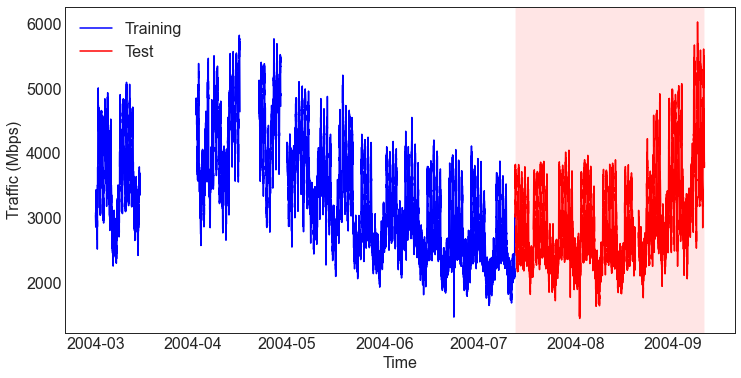

In [19]:
plt.figure(figsize=[12, 6])
plt.plot(df_ts.index[:train_length], df_ts['data'][:train_length], label='Training', color='blue')
plt.plot(df_ts.index[train_length:], df_ts['data'][train_length:], label='Test', color='red')
plt.axvspan(df_ts.index[train_length:][0], df_ts.index[train_length:][-1],  facecolor='r', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Traffic (Mbps)')
plt.legend(loc='best')
# plt.show()
plt.savefig('training_test_split.pdf', bbox_inches = 'tight', pad_inches = 0.1)

Plot the training / testing split:

# Normalize the data

Calculate the min and max data based on the training data set:

In [20]:
max_list = np.max(data[:train_length], axis=0)

In [21]:
min_list = np.min(data[:train_length], axis=0)

Normalize the data and fill the data:

In [22]:
data = (data - min_list) / (max_list - min_list)
data[np.isnan(data)] = 0  # fill the abnormal data with 0
data[np.isinf(data)] = 0

In [23]:
print(np.max(data[:train_length].flatten()))

1.0


In [24]:
print(np.min(data[:train_length].flatten()))

0.0


The training data is in a range of [0, 1] but the test data may be out of this range:

In [25]:
print(np.max(data.flatten()))

5.940447088662937


In [26]:
print(np.min(data.flatten()))

-0.0023245664896374284


# Build the supervised prediction problem

The input data is in the following format:
* x_data as input features: [data size, input historical steps, input channels]. Here the input channel number is the OD pair number.
* y_data as output targets: [data size, output prediction steps, output channels].

In [27]:
x_data = []
y_data = []

In [28]:
length = data.shape[0]
print(length)

48096


In [29]:
for i in range(length - history - horizon + 1):
    x = data[i:i+history, :]  # input historical time steps
    y = data[i+history:i+history+horizon:, :]  # output predicted time steps
    x_data.append(x)
    y_data.append(y)

In [30]:
x_data = np.array(x_data)
y_data = np.array(y_data)

In [31]:
x_data.shape

(48086, 10, 144)

In [32]:
y_data.shape

(48086, 1, 144)

Reshape x_data:

In [33]:
x_data = np.swapaxes(x_data, 1, 2)

Reshape y_data:

In [34]:
y_data = y_data.reshape(y_data.shape[0], -1)
y_data.shape

(48086, 144)

The last test_length samples are fixed as test data. The training data size may vary with the input historical time steps. The test data size may vary with the prediction horizon.

In [35]:
test_length = test_length - horizon + 1

In [36]:
train_valid_length = x_data.shape[0] - test_length

In [37]:
train_valid_length

38467

We further split a valid data set for hyper parameter tuning:

In [38]:
train_length = int(train_valid_length * 0.8)
valid_length = train_valid_length - train_length

In [39]:
train_length

30773

In [40]:
valid_length

7694

In [41]:
X_train = x_data[:train_length]
y_train = y_data[:train_length]
X_valid = x_data[train_length:train_valid_length]
y_valid = y_data[train_length:train_valid_length]
X_test = x_data[train_valid_length:]
y_test = y_data[train_valid_length:]

In [42]:
X_train.shape

(30773, 144, 10)

In [43]:
y_train.shape

(30773, 144)

In [44]:
X_valid.shape

(7694, 144, 10)

In [45]:
y_valid.shape

(7694, 144)

In [46]:
X_test.shape

(9619, 144, 10)

In [47]:
y_test.shape

(9619, 144)

# Build TSAI Datasets

Now we are ready to use the tsai package with its dataset definition:

In [48]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [49]:
X.shape

(38467, 144, 10)

In [50]:
y.shape

(38467, 144)

In [51]:
splits

((#30773) [0,1,2,3,4,5,6,7,8,9...],
 (#7694) [30773,30774,30775,30776,30777,30778,30779,30780,30781,30782...])

Make sure this is a regression task, instead of a classification task (using TSRegression as follows):

In [52]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#38467) [(TSTensor(vars:144, len:10), tensor([2.0469e-03, 5.1440e-02, 1.4299e-01, 1.5172e-02, 3.1831e-02, 2.1060e-02,
        5.6545e-02, 2.7428e-02, 2.8036e-01, 0.0000e+00, 4.0722e-02, 8.6615e-02,
        5.2351e-02, 2.0172e-01, 2.2308e-01, 5.7753e-02, 2.0265e-02, 1.5293e-01,
        9.8783e-02, 1.2363e-01, 1.7657e-01, 3.3181e-02, 2.1478e-01, 3.0738e-01,
        9.3064e-02, 9.6376e-02, 1.5660e-01, 3.1830e-02, 4.6944e-02, 1.3623e-01,
        4.7996e-02, 9.0038e-02, 3.8663e-02, 3.1614e-02, 1.1989e-01, 4.8892e-02,
        7.9847e-03, 2.8893e-02, 1.8501e-01, 3.5594e-02, 1.7775e-02, 6.8981e-02,
        8.2558e-02, 8.7485e-02, 1.3270e-01, 7.0169e-02, 1.0452e-01, 2.8641e-02,
        2.3876e-01, 3.3501e-02, 1.7263e-01, 9.0359e-02, 4.2771e-02, 4.5059e-01,
        2.0892e-01, 1.9877e-02, 5.5563e-02, 1.0113e-01, 1.0701e-01, 3.5482e-02,
        1.2049e-01, 1.0425e-01, 4.3749e-01, 9.8969e-02, 7.4077e-02, 9.2987e-02,
        1.2642e-01, 1.1211e-01, 1.5237e-01, 7.5094e-02, 2.2026e-01, 1.6917e-01,
 

# Model Building and Hyperparameter Tuning

We use the hyperopt package to search for hyper parameters:

In [53]:
search_space = {
    'batch_size': hp.choice('bs', [16, 32, 64, 128]),
    "lr": hp.choice('lr', [0.1, 0.01, 0.001]),
    "epochs": hp.choice('epochs', [20, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    # "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    "optimizer": hp.choice('optimizer', [Adam]),
    # model parameters
    "layers": hp.choice('layers', [[25, 25, 25, 25, 25, 25, 25, 25], [25, 25, 25, 25, 25, 25], [25, 25, 25, 25]]),
    "ks": hp.choice('ks', [7, 5, 3]),
    "conv_dropout": hp.choice('conv_dropout', [0.0, 0.1, 0.2, 0.5])
}

In [54]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x229632db4c8>,
 'lr': <hyperopt.pyll.base.Apply at 0x229632d2948>,
 'epochs': <hyperopt.pyll.base.Apply at 0x229632df788>,
 'patience': <hyperopt.pyll.base.Apply at 0x229632dfdc8>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x2296329ccc8>,
 'layers': <hyperopt.pyll.base.Apply at 0x2296333d408>,
 'ks': <hyperopt.pyll.base.Apply at 0x2296333de48>,
 'conv_dropout': <hyperopt.pyll.base.Apply at 0x22963273ec8>}

In [55]:
# clear memory 
gc.collect()

40

In [56]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:", params)
        batch_size = params["batch_size"]
    
        # Create data loader
        tfms  = [None, [TSRegression()]]
        dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = TCN
        k = {
            'layers': params['layers'],
            'ks': params['ks'],
            'conv_dropout': params['conv_dropout']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
        
        # Add a Sigmoid layer
        model = nn.Sequential(model, nn.Sigmoid())
    
        # Training the model
        learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
        print(elapsed)
    
        vals = learn.recorder.values[-1]
        print(vals)
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.1, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
  0%|                                                                          | 0/100 [00:06<?, ?trial/s, best loss=?]

No improvement since epoch 86: early stopping                                                                          
  0%|                                                                          | 0/100 [15:06<?, ?trial/s, best loss=?]

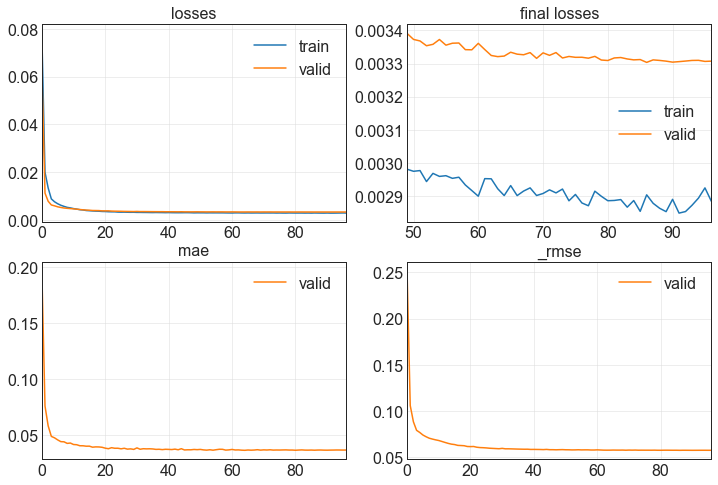

901.2388398647308                                                                                                      
[0.0028839653823524714, 0.0033071243669837713, 0.03671621158719063, 0.057507600635290146]                              
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
  1%|▍                                        | 1/100 [15:12<24:57:09, 907.37s/trial, best loss: 0.0033071243669837713]

No improvement since epoch 8: early stopping                                                                           
  1%|▍                                        | 1/100 [16:19<24:57:09, 907.37s/trial, best loss: 0.0033071243669837713]

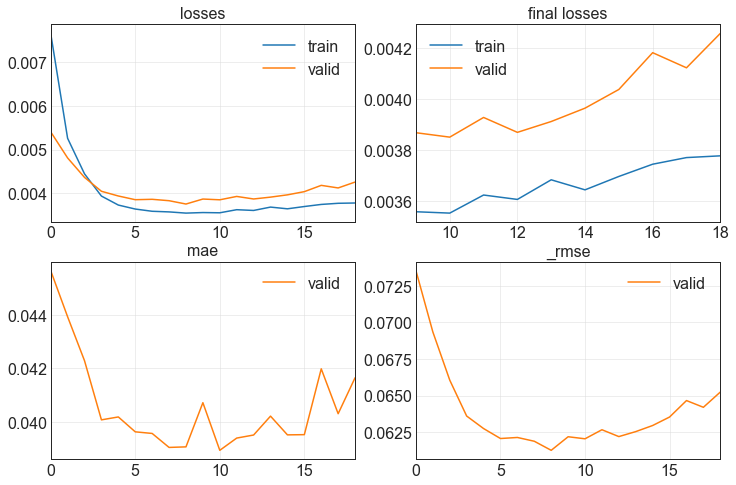

68.07159972190857                                                                                                      
[0.003777523757889867, 0.004257022403180599, 0.04164859279990196, 0.0652458593249321]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.1, 'epochs': 20, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
  2%|▊                                        | 2/100 [16:24<17:53:07, 657.01s/trial, best loss: 0.0033071243669837713]

No improvement since epoch 2: early stopping                                                                           
  2%|▊                                        | 2/100 [18:21<17:53:07, 657.01s/trial, best loss: 0.0033071243669837713]

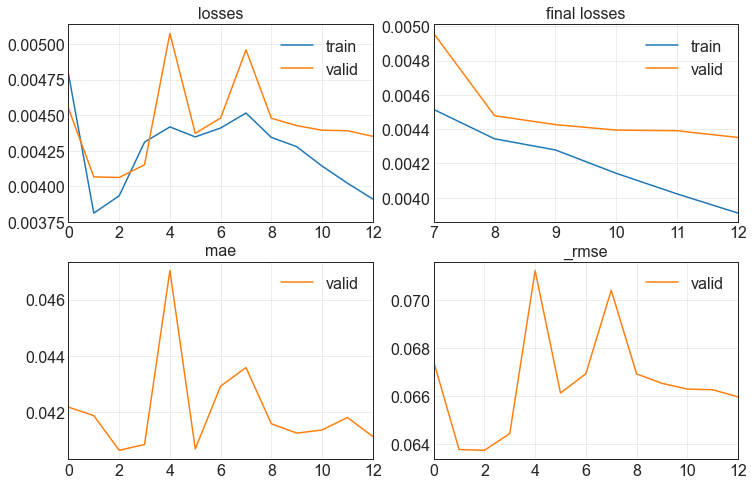

117.29938960075378                                                                                                     
[0.003910372033715248, 0.004351736977696419, 0.04114297032356262, 0.06596770137548447]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.1, 'epochs': 20, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
  3%|█▏                                       | 3/100 [18:26<13:22:40, 496.49s/trial, best loss: 0.0033071243669837713]

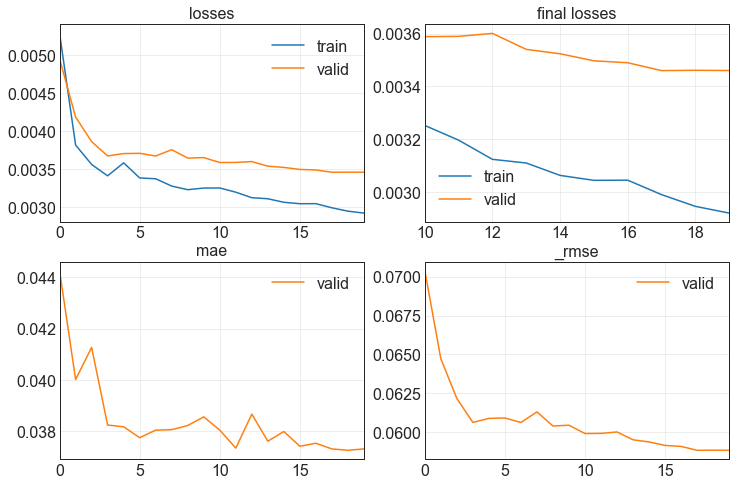

690.0597629547119                                                                                                      
[0.0029214960522949696, 0.0034601911902427673, 0.03730788081884384, 0.05882340669631958]                               
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
  4%|█▋                                       | 4/100 [30:01<14:49:32, 555.97s/trial, best loss: 0.0033071243669837713]

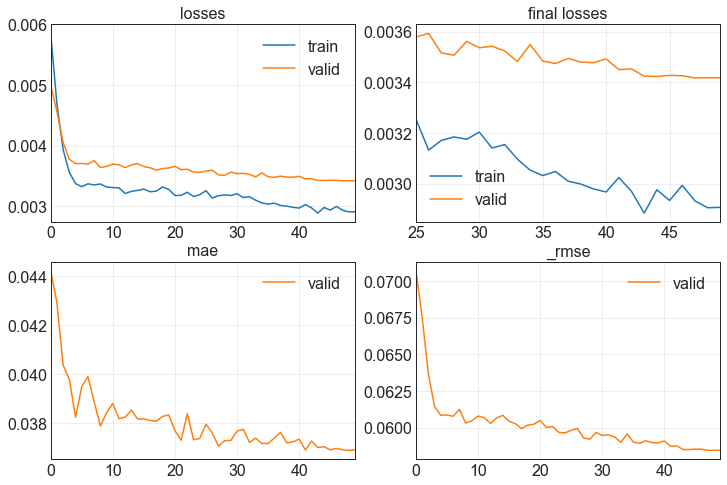

1725.4382374286652                                                                                                     
[0.002906494541093707, 0.003417384810745716, 0.03691255301237106, 0.05845838785171509]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 5}
TCN                                                                                                                    
  5%|██                                       | 5/100 [58:51<23:58:01, 908.22s/trial, best loss: 0.0033071243669837713]

No improvement since epoch 44: early stopping                                                                          
  5%|█▉                                     | 5/100 [1:01:45<23:58:01, 908.22s/trial, best loss: 0.0033071243669837713]

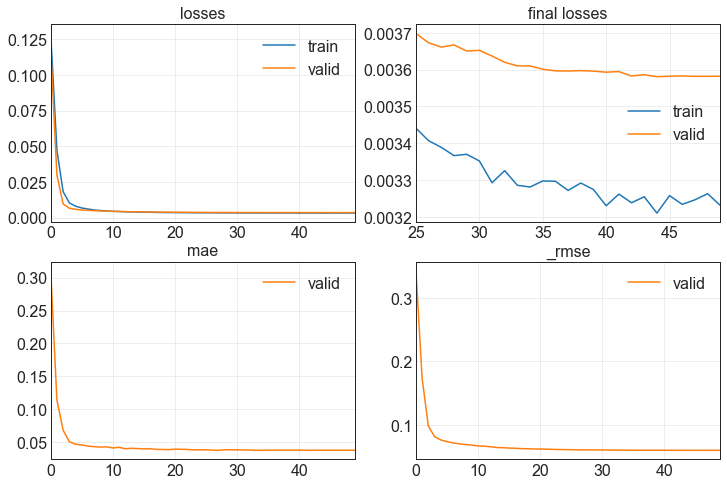

174.51159858703613                                                                                                     
[0.003230718430131674, 0.003582123899832368, 0.03818291053175926, 0.059850845485925674]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
  6%|██▎                                    | 6/100 [1:01:51<18:00:17, 689.55s/trial, best loss: 0.0033071243669837713]

No improvement since epoch 1: early stopping                                                                           
  6%|██▎                                    | 6/100 [1:05:25<18:00:17, 689.55s/trial, best loss: 0.0033071243669837713]

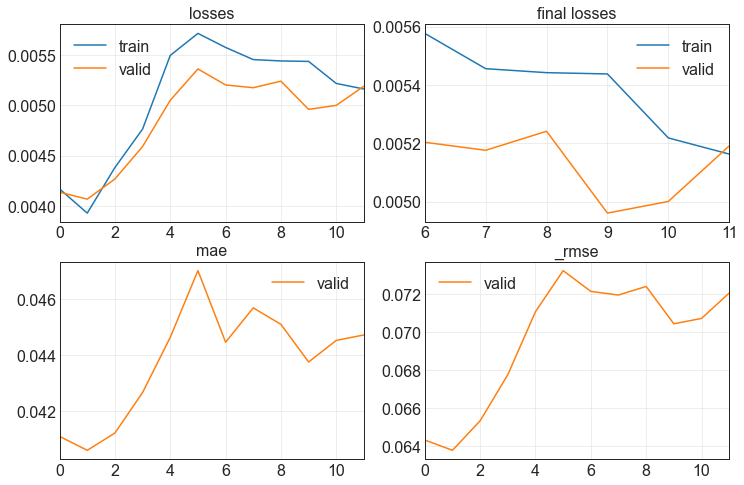

214.44172191619873                                                                                                     
[0.005162926856428385, 0.0051907822489738464, 0.044708289206027985, 0.07204709202051163]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
  7%|██▋                                    | 7/100 [1:05:30<14:10:02, 548.42s/trial, best loss: 0.0033071243669837713]

No improvement since epoch 11: early stopping                                                                          
  7%|██▋                                    | 7/100 [1:10:20<14:10:02, 548.42s/trial, best loss: 0.0033071243669837713]

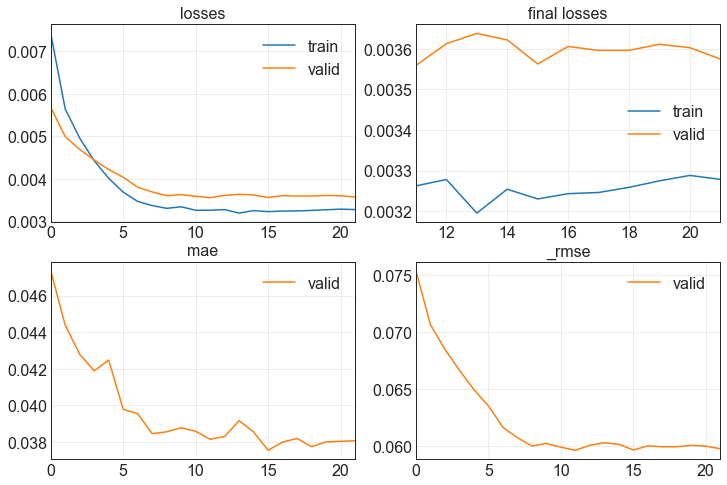

290.52473759651184                                                                                                     
[0.0032786154188215733, 0.0035748106893152, 0.03807644918560982, 0.05978973209857941]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.1, 'epochs': 50, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 5}
TCN                                                                                                                    
  8%|███                                    | 8/100 [1:10:25<12:04:25, 472.45s/trial, best loss: 0.0033071243669837713]

No improvement since epoch 11: early stopping                                                                          
  8%|███                                    | 8/100 [1:17:44<12:04:25, 472.45s/trial, best loss: 0.0033071243669837713]

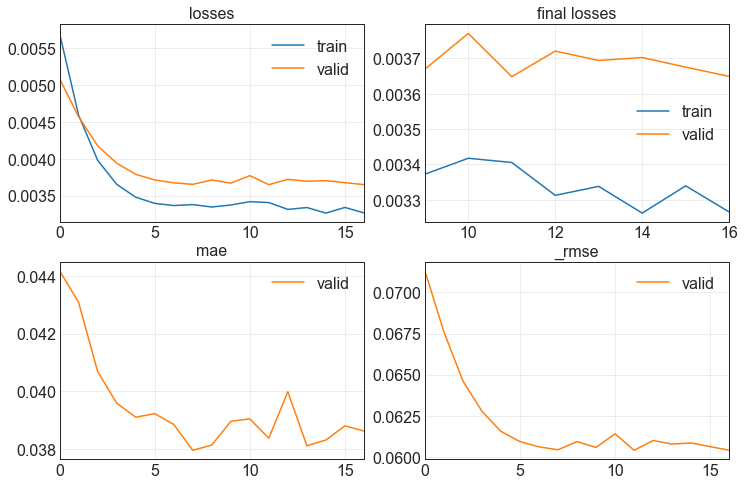

439.52691292762756                                                                                                     
[0.003265536855906248, 0.0036492354702204466, 0.038616616278886795, 0.06040889024734497]                               
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.1, 'epochs': 20, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
  9%|███▌                                   | 9/100 [1:17:49<11:43:41, 463.97s/trial, best loss: 0.0033071243669837713]

No improvement since epoch 0: early stopping                                                                           
  9%|███▌                                   | 9/100 [1:25:45<11:43:41, 463.97s/trial, best loss: 0.0033071243669837713]

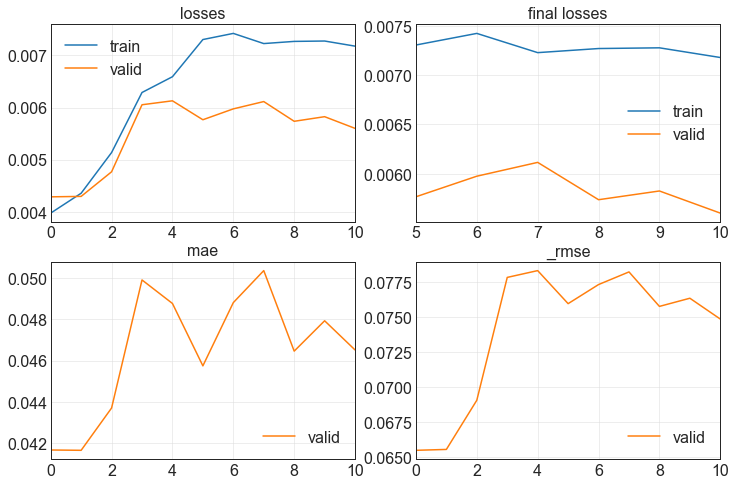

476.1387641429901                                                                                                      
[0.007178742904216051, 0.0056009553372859955, 0.04651027172803879, 0.0748395025730133]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.1, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 5}
TCN                                                                                                                    
 10%|███▊                                  | 10/100 [1:25:50<11:43:32, 469.03s/trial, best loss: 0.0033071243669837713]

No improvement since epoch 6: early stopping                                                                           
 10%|███▊                                  | 10/100 [1:27:01<11:43:32, 469.03s/trial, best loss: 0.0033071243669837713]

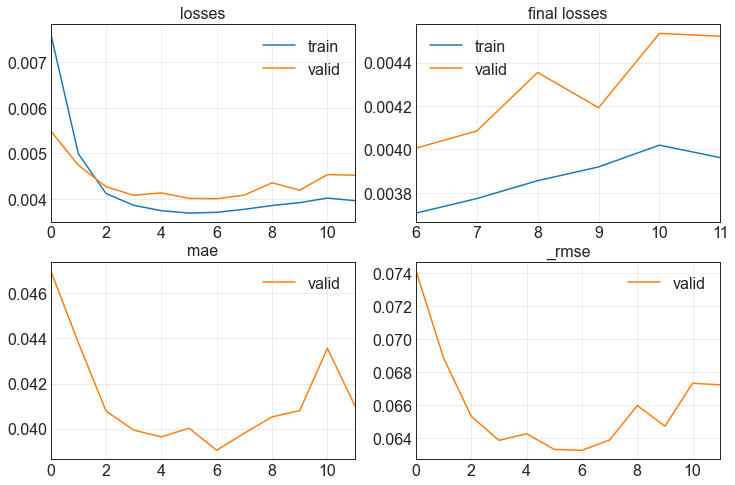

71.33013343811035                                                                                                      
[0.0039617447182536125, 0.004520980175584555, 0.04099828749895096, 0.06723824143409729]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.5, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 5}
TCN                                                                                                                    
 11%|████▎                                  | 11/100 [1:27:06<8:40:49, 351.12s/trial, best loss: 0.0033071243669837713]

No improvement since epoch 14: early stopping                                                                          
 11%|████▎                                  | 11/100 [1:38:38<8:40:49, 351.12s/trial, best loss: 0.0033071243669837713]

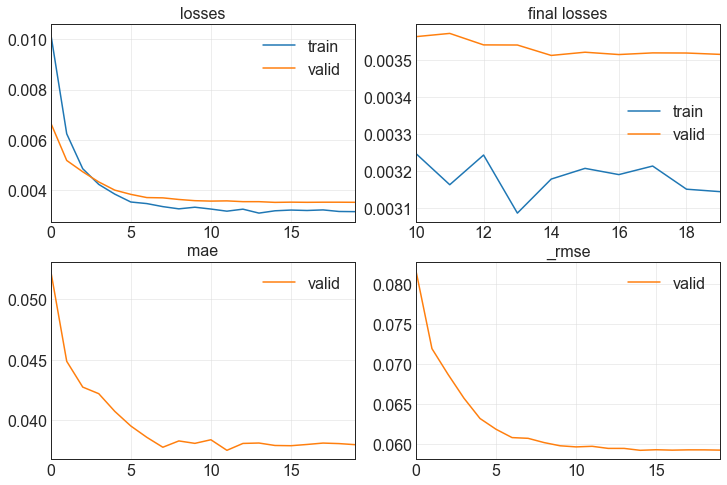

692.2461004257202                                                                                                      
[0.003144429996609688, 0.00351610011421144, 0.037969205528497696, 0.05929671227931976]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 5}
TCN                                                                                                                    
 12%|████▌                                 | 12/100 [1:38:43<11:07:06, 454.85s/trial, best loss: 0.0033071243669837713]

No improvement since epoch 9: early stopping                                                                           
 12%|████▌                                 | 12/100 [1:44:05<11:07:06, 454.85s/trial, best loss: 0.0033071243669837713]

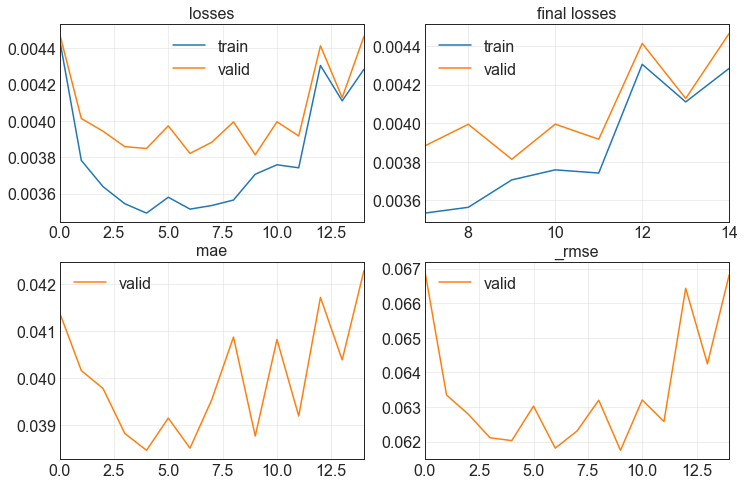

322.43246841430664                                                                                                     
[0.004283973481506109, 0.004465047735720873, 0.04229096323251724, 0.06682100892066956]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.2, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 13%|████▉                                 | 13/100 [1:44:10<10:03:58, 416.54s/trial, best loss: 0.0033071243669837713]

No improvement since epoch 0: early stopping                                                                           
 13%|████▉                                 | 13/100 [1:48:54<10:03:58, 416.54s/trial, best loss: 0.0033071243669837713]

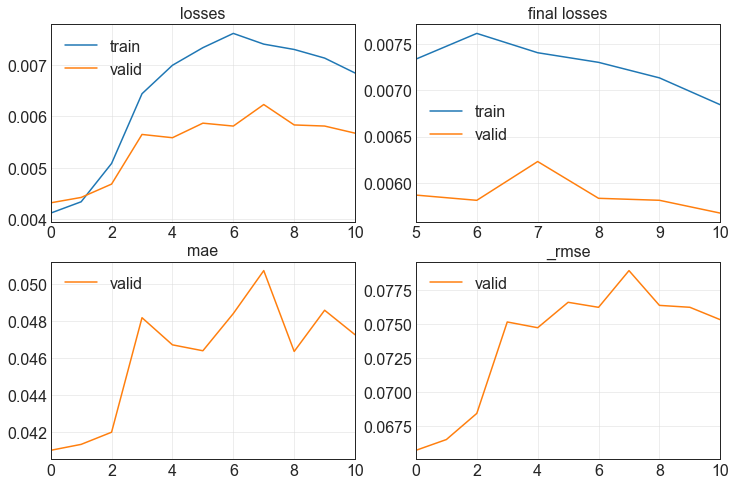

284.59024930000305                                                                                                     
[0.0068432847037911415, 0.005675506312400103, 0.047255050390958786, 0.07533595710992813]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 20, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 5}
TCN                                                                                                                    
 14%|█████▍                                 | 14/100 [1:48:59<9:02:18, 378.36s/trial, best loss: 0.0033071243669837713]

No improvement since epoch 2: early stopping                                                                           
 14%|█████▍                                 | 14/100 [1:51:57<9:02:18, 378.36s/trial, best loss: 0.0033071243669837713]

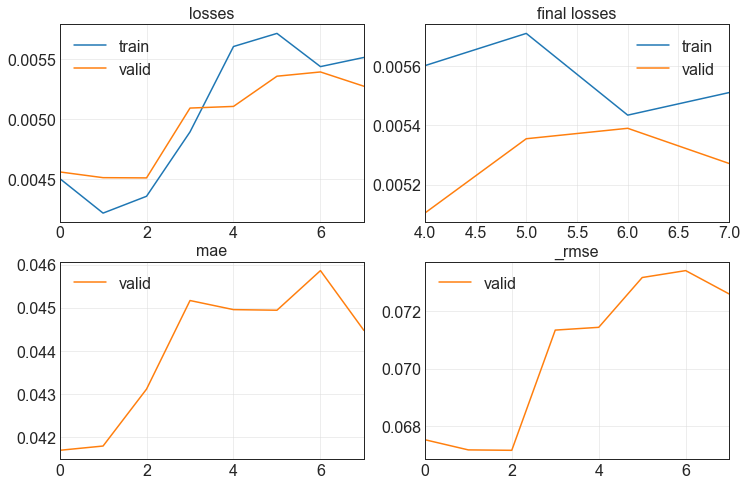

178.1488287448883                                                                                                      
[0.0055111548863351345, 0.005271425470709801, 0.04447125270962715, 0.07260458171367645]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 15%|█████▊                                 | 15/100 [1:52:02<7:32:55, 319.71s/trial, best loss: 0.0033071243669837713]

No improvement since epoch 1: early stopping                                                                           
 15%|█████▊                                 | 15/100 [1:56:30<7:32:55, 319.71s/trial, best loss: 0.0033071243669837713]

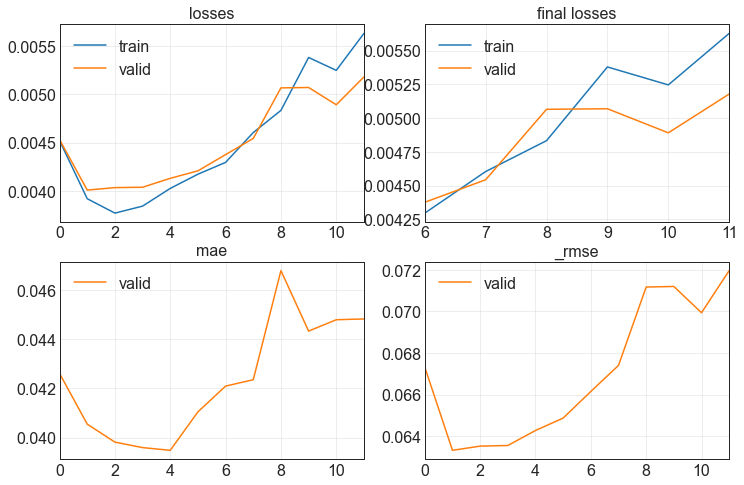

268.165141582489                                                                                                       
[0.005627920851111412, 0.005178550723940134, 0.04482731223106384, 0.0719621479511261]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.1, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 5}
TCN                                                                                                                    
 16%|██████▏                                | 16/100 [1:56:35<7:07:53, 305.64s/trial, best loss: 0.0033071243669837713]

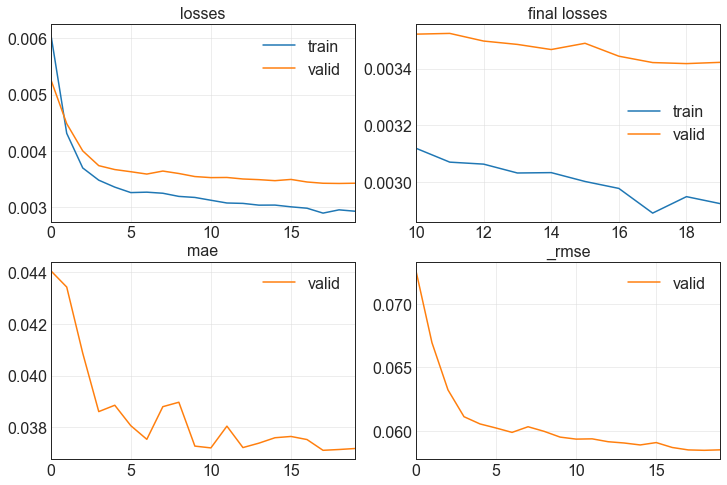

355.35918283462524                                                                                                     
[0.002922909101471305, 0.0034219366498291492, 0.03718506917357445, 0.05849732458591461]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 17%|██████▋                                | 17/100 [2:02:35<7:25:22, 321.95s/trial, best loss: 0.0033071243669837713]

No improvement since epoch 2: early stopping                                                                           
 17%|██████▋                                | 17/100 [2:11:56<7:25:22, 321.95s/trial, best loss: 0.0033071243669837713]

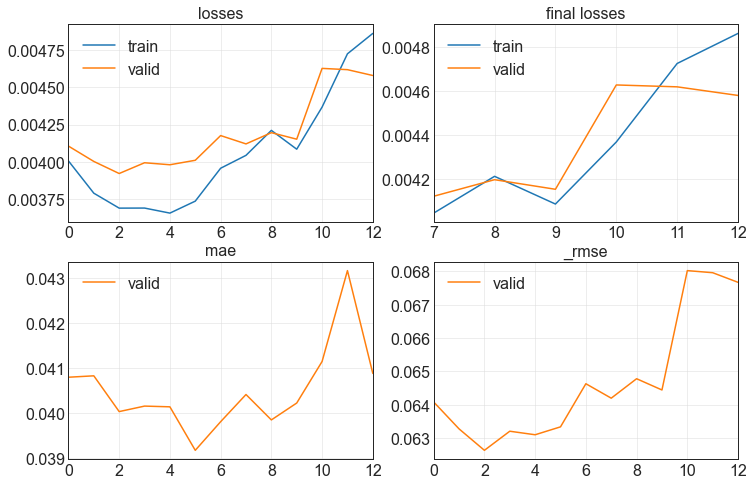

561.3242514133453                                                                                                      
[0.004861799534410238, 0.004579722881317139, 0.0408836230635643, 0.06767363101243973]                                  
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 18%|███████                                | 18/100 [2:12:01<9:00:02, 395.16s/trial, best loss: 0.0033071243669837713]

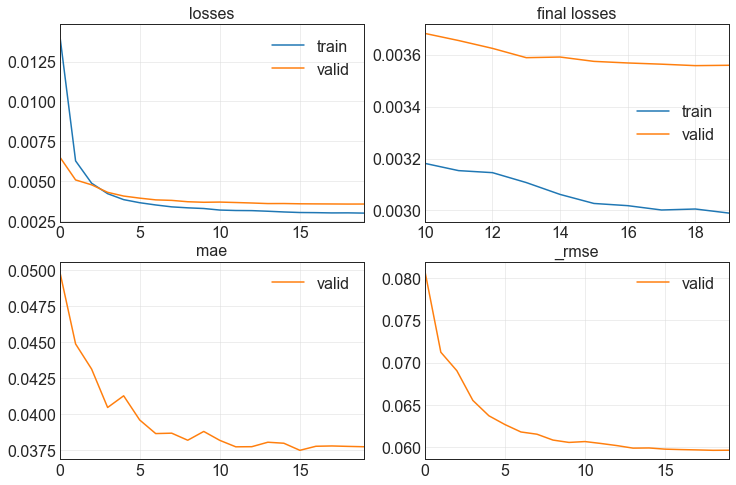

111.2300295829773                                                                                                      
[0.002989736385643482, 0.00355927855707705, 0.03772455453872681, 0.059659693390131]                                    
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.1, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 5}
TCN                                                                                                                    
 19%|███████▍                               | 19/100 [2:13:57<7:00:22, 311.39s/trial, best loss: 0.0033071243669837713]

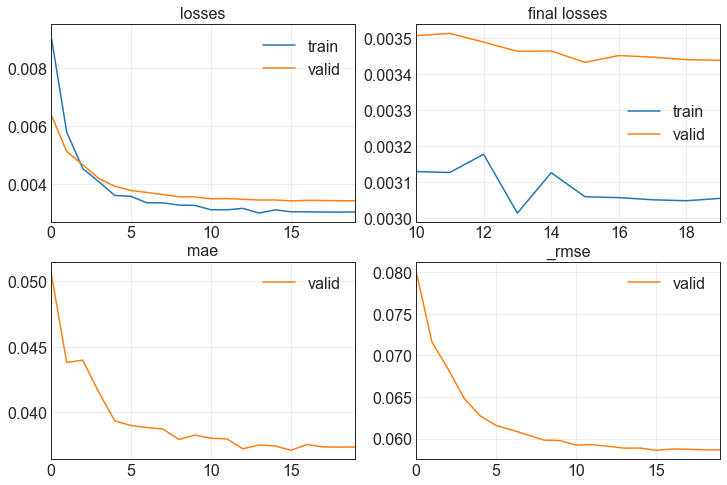

515.5160021781921                                                                                                      
[0.003055060049518943, 0.003438916290178895, 0.0373619981110096, 0.05864226818084717]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 20%|███████▊                               | 20/100 [2:22:37<8:18:42, 374.03s/trial, best loss: 0.0033071243669837713]

No improvement since epoch 82: early stopping                                                                          
 20%|███████▊                               | 20/100 [2:36:32<8:18:42, 374.03s/trial, best loss: 0.0033071243669837713]

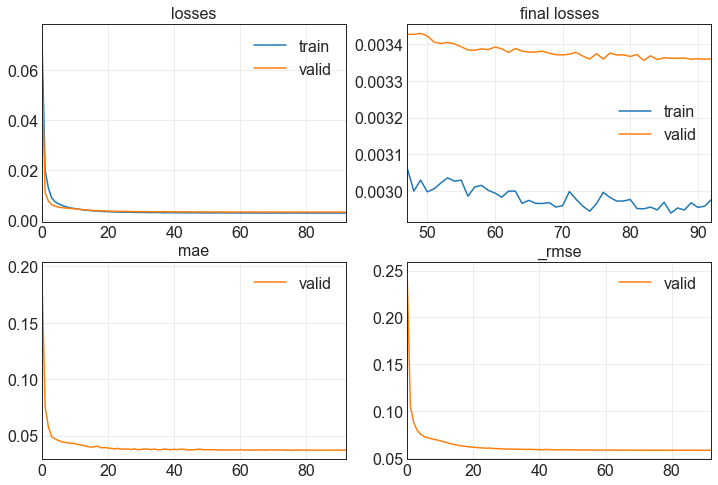

835.813383102417                                                                                                       
[0.00297642988152802, 0.0033601191826164722, 0.0371311753988266, 0.05796653404831886]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 21%|███████▉                              | 21/100 [2:36:37<11:16:44, 513.98s/trial, best loss: 0.0033071243669837713]

No improvement since epoch 87: early stopping                                                                          
 21%|███████▉                              | 21/100 [2:50:47<11:16:44, 513.98s/trial, best loss: 0.0033071243669837713]

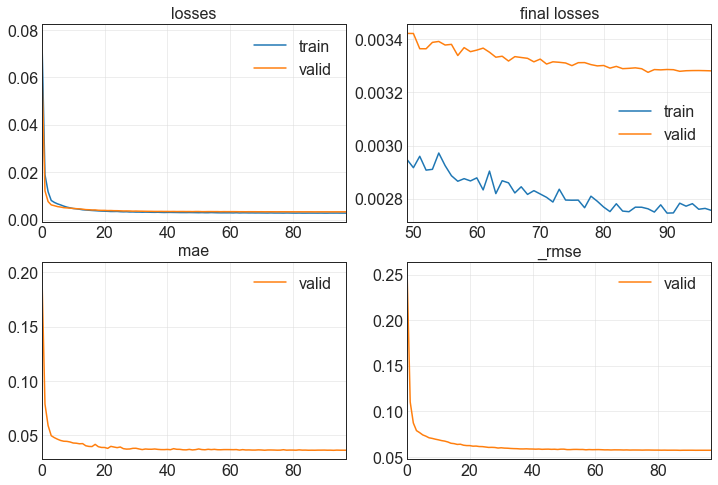

849.6211731433868                                                                                                      
[0.0027558545116335154, 0.0032807798124849796, 0.036290816962718964, 0.0572780966758728]                               
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 22%|████████▎                             | 22/100 [2:50:52<13:20:54, 616.08s/trial, best loss: 0.0032807798124849796]

No improvement since epoch 69: early stopping                                                                          
 22%|████████▎                             | 22/100 [3:02:25<13:20:54, 616.08s/trial, best loss: 0.0032807798124849796]

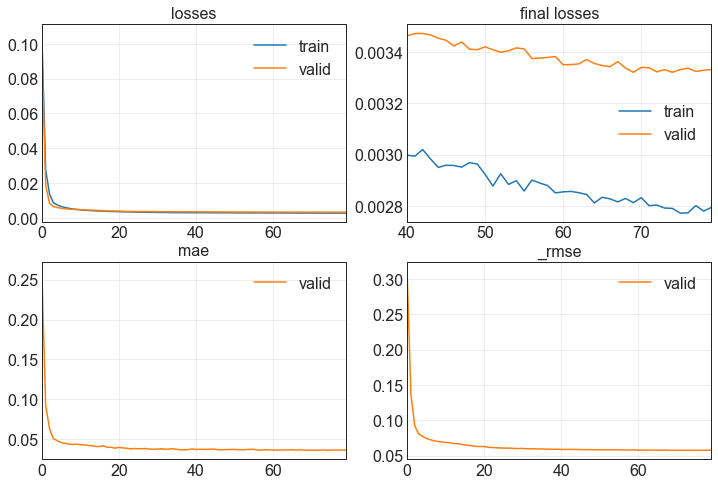

693.8431425094604                                                                                                      
[0.0027949404902756214, 0.0033313636668026447, 0.03664770349860191, 0.05771796405315399]                               
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 23%|████████▋                             | 23/100 [3:02:30<13:42:23, 640.83s/trial, best loss: 0.0032807798124849796]

No improvement since epoch 75: early stopping                                                                          
 23%|████████▋                             | 23/100 [3:14:56<13:42:23, 640.83s/trial, best loss: 0.0032807798124849796]

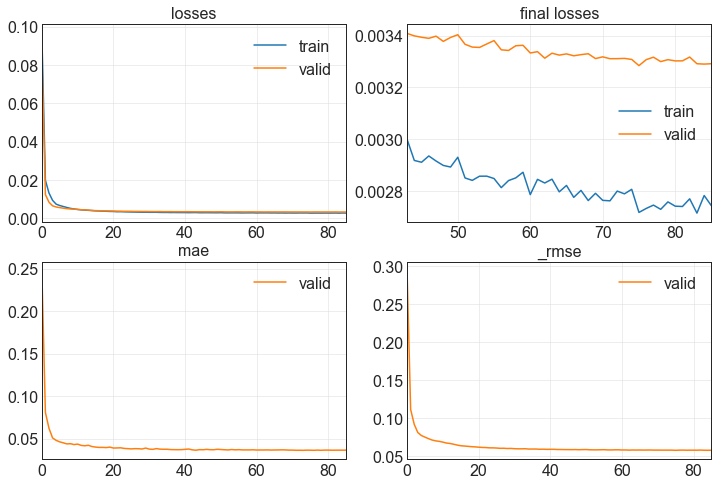

746.4326004981995                                                                                                      
[0.002744134981185198, 0.0032916974741965532, 0.03649409860372543, 0.05737331509590149]                                
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 24%|█████████                             | 24/100 [3:15:02<14:13:38, 673.92s/trial, best loss: 0.0032807798124849796]

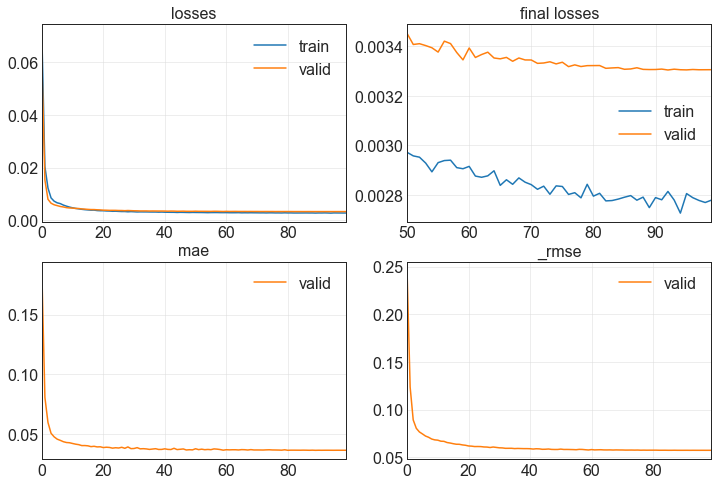

867.4031586647034                                                                                                      
[0.0027798679657280445, 0.003304871963337064, 0.036617461591959, 0.05748801678419113]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 25%|█████████▌                            | 25/100 [3:29:34<15:16:44, 733.39s/trial, best loss: 0.0032807798124849796]

No improvement since epoch 88: early stopping                                                                          
 25%|█████████▌                            | 25/100 [3:43:53<15:16:44, 733.39s/trial, best loss: 0.0032807798124849796]

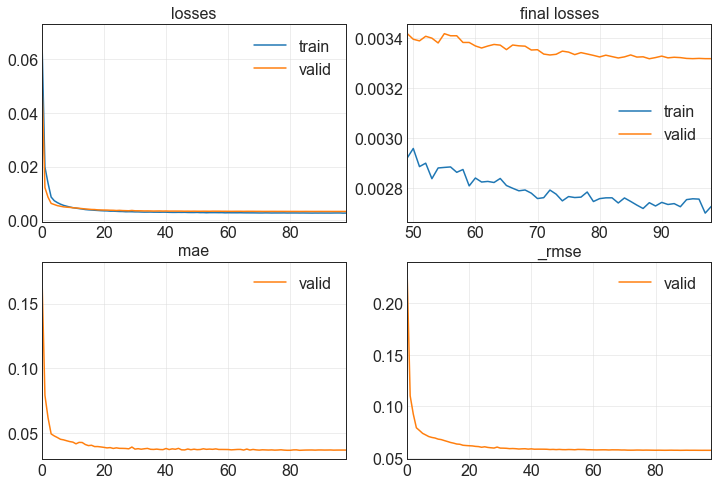

859.3907861709595                                                                                                      
[0.0027287385892122984, 0.0033168066293001175, 0.0367402583360672, 0.057591717690229416]                               
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 26%|█████████▉                            | 26/100 [3:43:58<15:52:52, 772.60s/trial, best loss: 0.0032807798124849796]

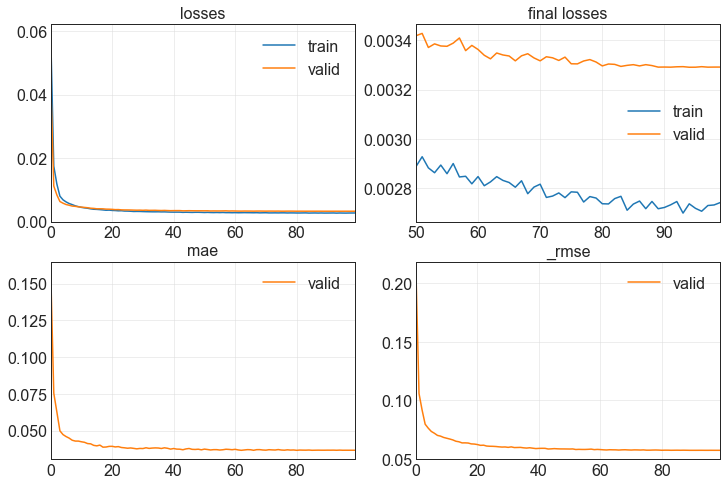

867.8586421012878                                                                                                      
[0.0027426755987107754, 0.0032912783790379763, 0.03666532412171364, 0.0573696605861187]                                
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 27%|██████████▎                           | 27/100 [3:58:30<16:16:29, 802.60s/trial, best loss: 0.0032807798124849796]

No improvement since epoch 84: early stopping                                                                          
 27%|██████████▎                           | 27/100 [4:12:25<16:16:29, 802.60s/trial, best loss: 0.0032807798124849796]

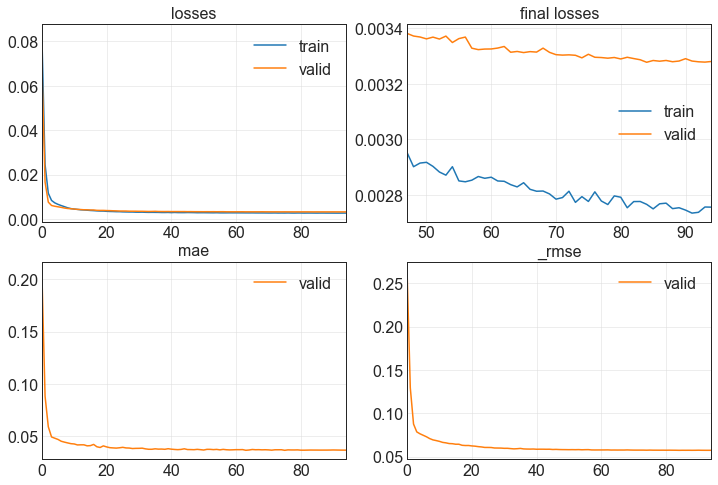

834.9333865642548                                                                                                      
[0.002756131114438176, 0.0032810692209750414, 0.03638976812362671, 0.057280611246824265]                               
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 28%|██████████▋                           | 28/100 [4:12:30<16:16:27, 813.72s/trial, best loss: 0.0032807798124849796]

No improvement since epoch 89: early stopping                                                                          
 28%|██████████▋                           | 28/100 [4:27:09<16:16:27, 813.72s/trial, best loss: 0.0032807798124849796]

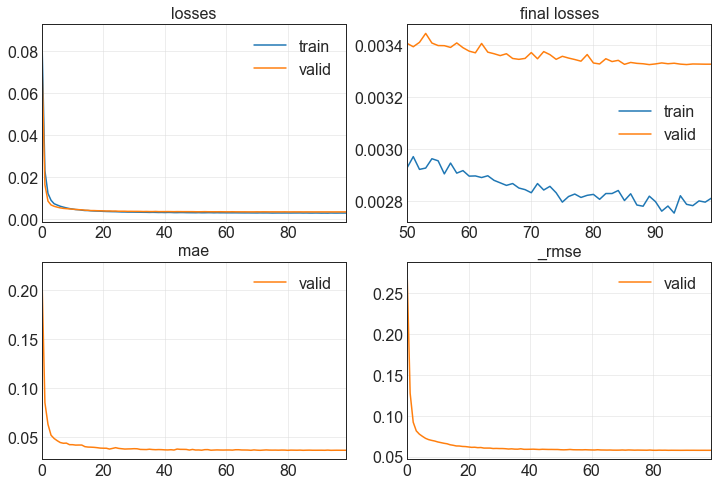

879.480306148529                                                                                                       
[0.002811678685247898, 0.0033269934356212616, 0.036482516676187515, 0.057680100202560425]                              
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 29%|███████████                           | 29/100 [4:27:14<16:27:55, 834.86s/trial, best loss: 0.0032807798124849796]

No improvement since epoch 71: early stopping                                                                          
 29%|███████████                           | 29/100 [4:39:14<16:27:55, 834.86s/trial, best loss: 0.0032807798124849796]

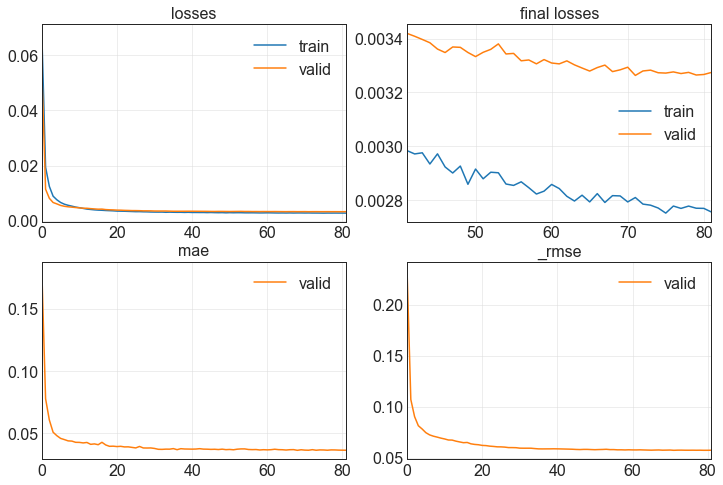

719.9380750656128                                                                                                      
[0.0027557844296097755, 0.0032745387870818377, 0.03627363219857216, 0.05722358450293541]                               
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 30%|███████████▍                          | 30/100 [4:39:19<15:35:26, 801.80s/trial, best loss: 0.0032745387870818377]

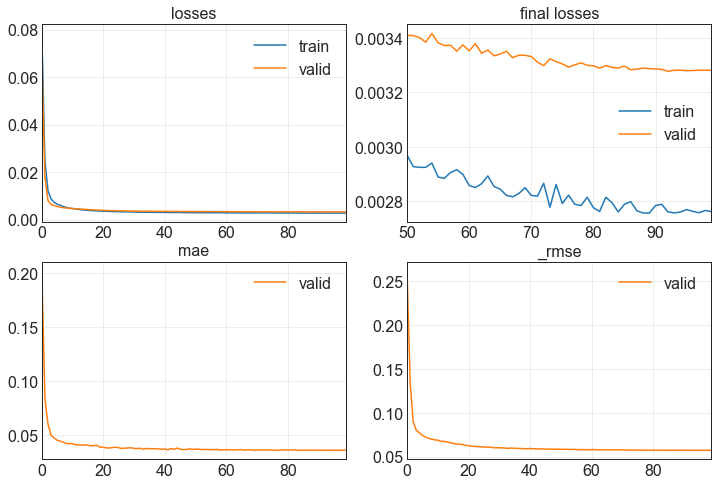

879.5891919136047                                                                                                      
[0.0027624221984297037, 0.0032816340681165457, 0.03641786053776741, 0.05728554725646973]                               
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 31%|███████████▊                          | 31/100 [4:54:03<15:50:32, 826.55s/trial, best loss: 0.0032745387870818377]

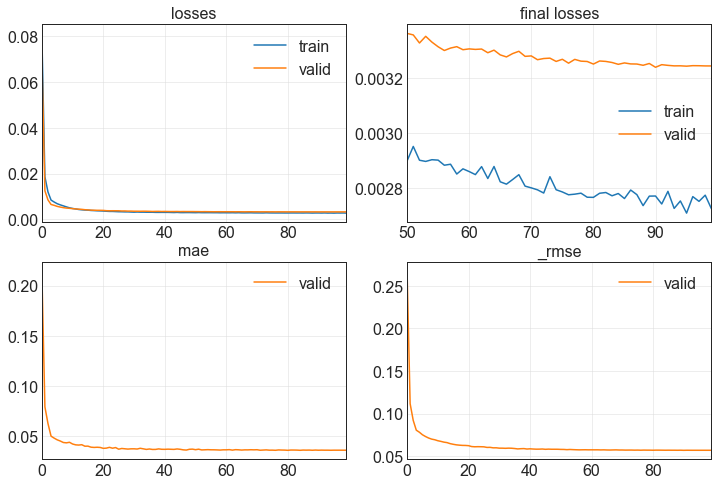

879.5818018913269                                                                                                      
[0.0027246084064245224, 0.0032448098063468933, 0.036277614533901215, 0.0569632351398468]                               
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 32%|████████████▏                         | 32/100 [5:08:47<15:56:22, 843.86s/trial, best loss: 0.0032448098063468933]

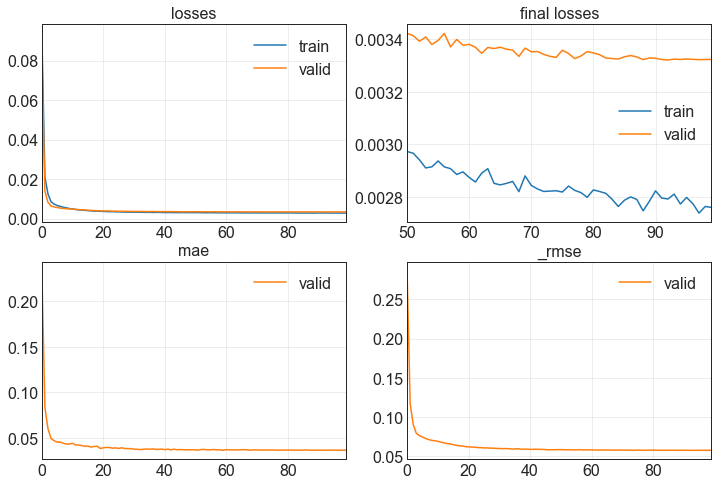

879.1461598873138                                                                                                      
[0.0027595406863838434, 0.0033239112235605717, 0.03658628091216087, 0.05765337124466896]                               
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 33%|████████████▌                         | 33/100 [5:23:31<15:55:43, 855.87s/trial, best loss: 0.0032448098063468933]

No improvement since epoch 83: early stopping                                                                          
 33%|████████████▌                         | 33/100 [5:37:17<15:55:43, 855.87s/trial, best loss: 0.0032448098063468933]

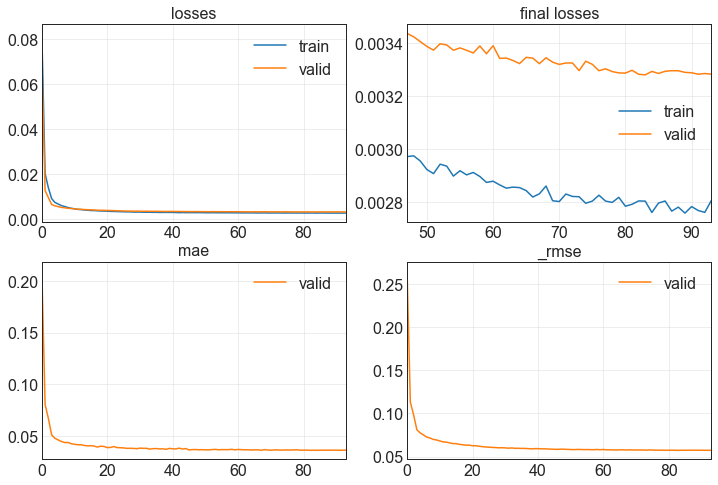

826.6564695835114                                                                                                      
[0.0028061934281140566, 0.0032831598073244095, 0.03662407398223877, 0.05729886516928673]                               
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 34%|████████████▉                         | 34/100 [5:37:23<15:33:22, 848.52s/trial, best loss: 0.0032448098063468933]

No improvement since epoch 76: early stopping                                                                          
 34%|████████████▉                         | 34/100 [5:43:54<15:33:22, 848.52s/trial, best loss: 0.0032448098063468933]

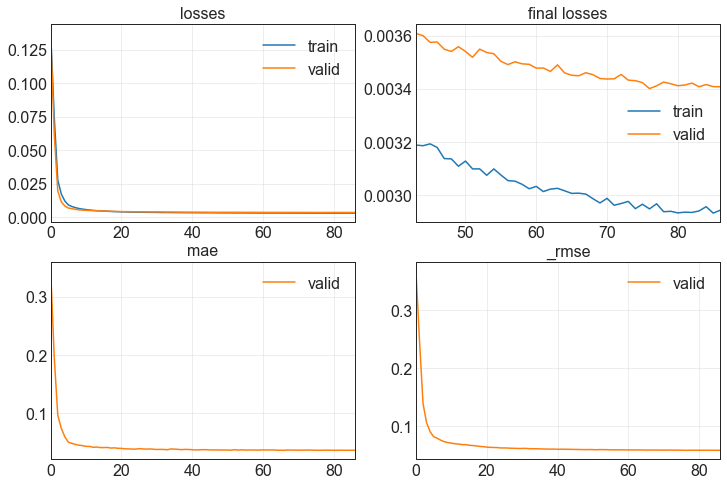

391.91074204444885                                                                                                     
[0.0029427579138427973, 0.0034073584247380495, 0.03690863028168678, 0.05837258696556091]                               
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 50, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 35%|█████████████▎                        | 35/100 [5:43:59<12:52:22, 712.96s/trial, best loss: 0.0032448098063468933]

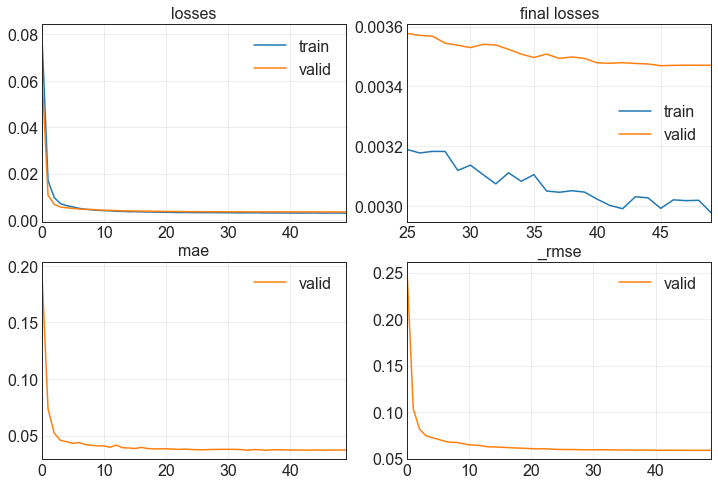

327.50717759132385                                                                                                     
[0.0029753963463008404, 0.003470403142273426, 0.03718271106481552, 0.05891013145446777]                                
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 36%|█████████████▋                        | 36/100 [5:49:32<10:38:39, 598.74s/trial, best loss: 0.0032448098063468933]

No improvement since epoch 74: early stopping                                                                          
 36%|█████████████▋                        | 36/100 [6:02:23<10:38:39, 598.74s/trial, best loss: 0.0032448098063468933]

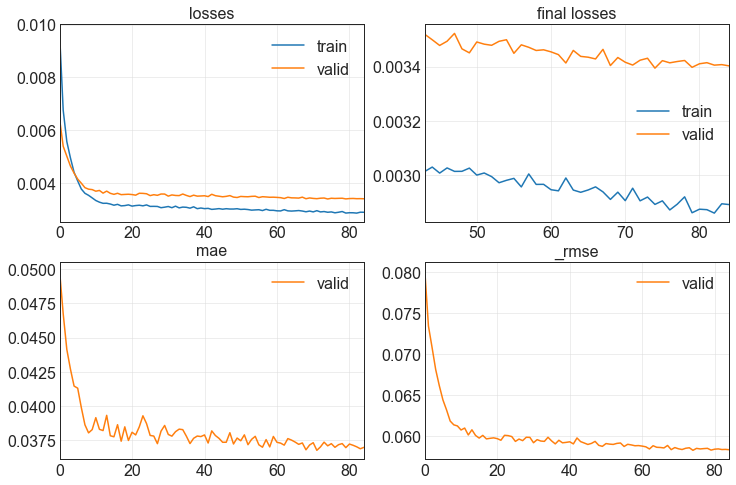

771.9989488124847                                                                                                      
[0.002890900010243058, 0.0034028494264930487, 0.03697887435555458, 0.05833394080400467]                                
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 50, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 37%|██████████████                        | 37/100 [6:02:28<11:24:43, 652.13s/trial, best loss: 0.0032448098063468933]

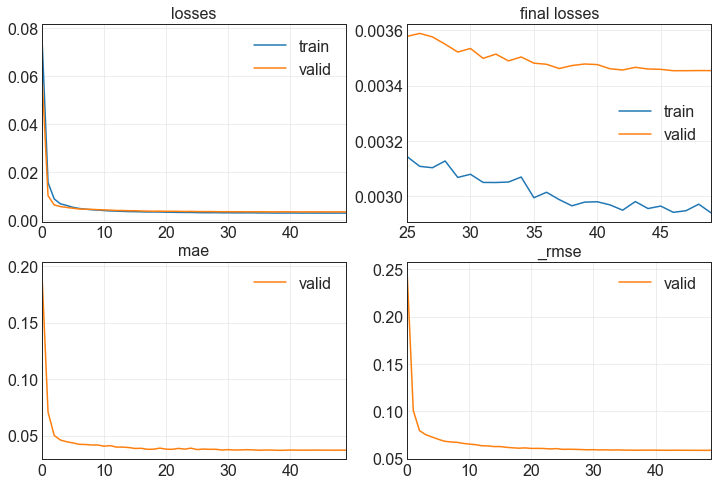

439.8755588531494                                                                                                      
[0.0029399918857961893, 0.003454076824709773, 0.03714060038328171, 0.058771390467882156]                               
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 38%|██████████████▍                       | 38/100 [6:09:53<10:09:32, 589.87s/trial, best loss: 0.0032448098063468933]

No improvement since epoch 76: early stopping                                                                          
 38%|██████████████▍                       | 38/100 [6:14:57<10:09:32, 589.87s/trial, best loss: 0.0032448098063468933]

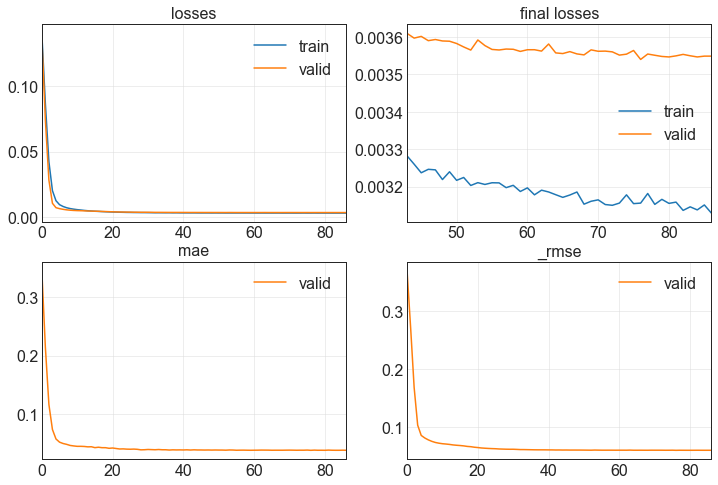

304.4720220565796                                                                                                      
[0.0031294473446905613, 0.0035485071130096912, 0.03776467964053154, 0.0595693364739418]                                
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 5}
TCN                                                                                                                    
 39%|███████████████▏                       | 39/100 [6:15:02<8:34:05, 505.67s/trial, best loss: 0.0032448098063468933]

No improvement since epoch 21: early stopping                                                                          
 39%|███████████████▏                       | 39/100 [6:19:00<8:34:05, 505.67s/trial, best loss: 0.0032448098063468933]

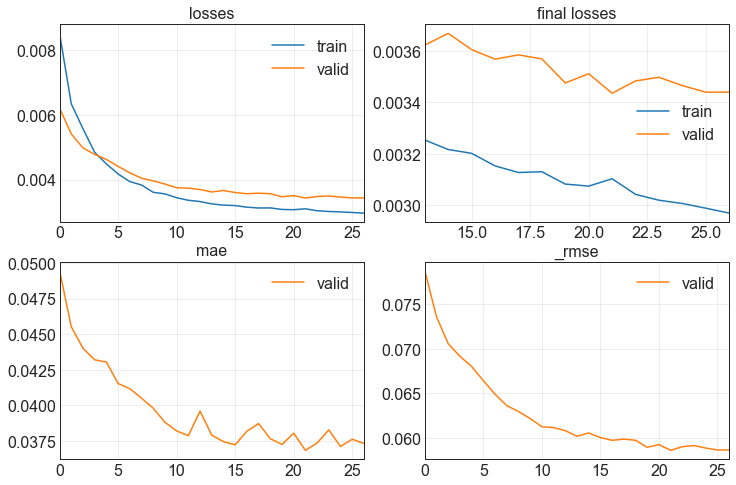

238.10141253471375                                                                                                     
[0.002970367670059204, 0.003439562860876322, 0.03732888028025627, 0.05864778906106949]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.1, 'epochs': 50, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 40%|███████████████▌                       | 40/100 [6:19:05<7:06:48, 426.81s/trial, best loss: 0.0032448098063468933]

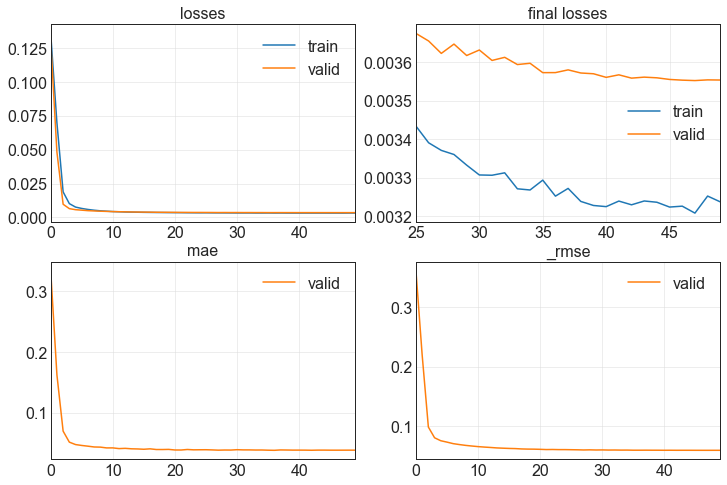

231.58901286125183                                                                                                     
[0.0032370914705097675, 0.0035532512702047825, 0.03800711780786514, 0.059609148651361465]                              
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 41%|███████████████▉                       | 41/100 [6:23:01<6:03:28, 369.64s/trial, best loss: 0.0032448098063468933]

No improvement since epoch 30: early stopping                                                                          
 41%|███████████████▉                       | 41/100 [6:27:38<6:03:28, 369.64s/trial, best loss: 0.0032448098063468933]

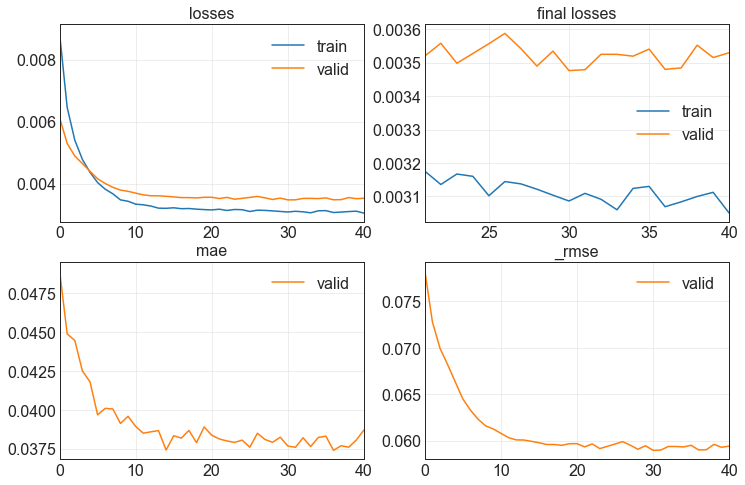

277.0084443092346                                                                                                      
[0.003050209954380989, 0.0035295162815600634, 0.038702238351106644, 0.0594097338616848]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 5}
TCN                                                                                                                    
 42%|████████████████▍                      | 42/100 [6:27:43<5:31:48, 343.25s/trial, best loss: 0.0032448098063468933]

No improvement since epoch 36: early stopping                                                                          
 42%|████████████████▍                      | 42/100 [6:40:11<5:31:48, 343.25s/trial, best loss: 0.0032448098063468933]

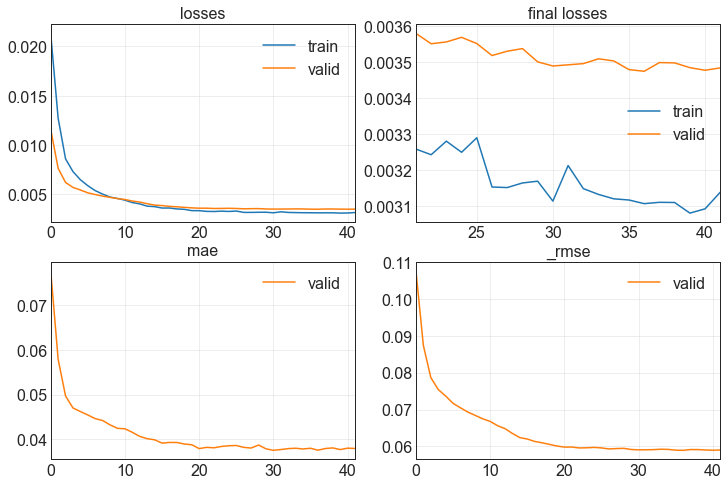

748.6350340843201                                                                                                      
[0.0031377188861370087, 0.003483149688690901, 0.037932541221380234, 0.05901821330189705]                               
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 50, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 43%|████████████████▊                      | 43/100 [6:40:16<7:22:56, 466.26s/trial, best loss: 0.0032448098063468933]

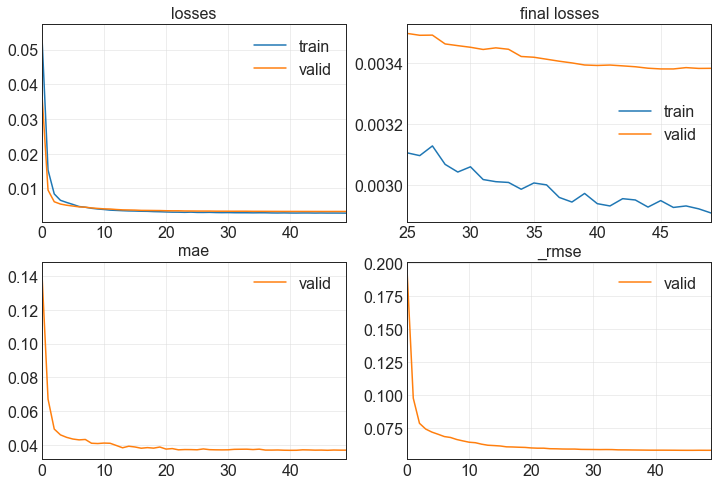

549.5360536575317                                                                                                      
[0.0029076221399009228, 0.003382513765245676, 0.03692847117781639, 0.05815938115119934]                                
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.1, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 5}
TCN                                                                                                                    
 44%|█████████████████▏                     | 44/100 [6:49:30<7:39:48, 492.66s/trial, best loss: 0.0032448098063468933]

No improvement since epoch 7: early stopping                                                                           
 44%|█████████████████▏                     | 44/100 [6:50:16<7:39:48, 492.66s/trial, best loss: 0.0032448098063468933]

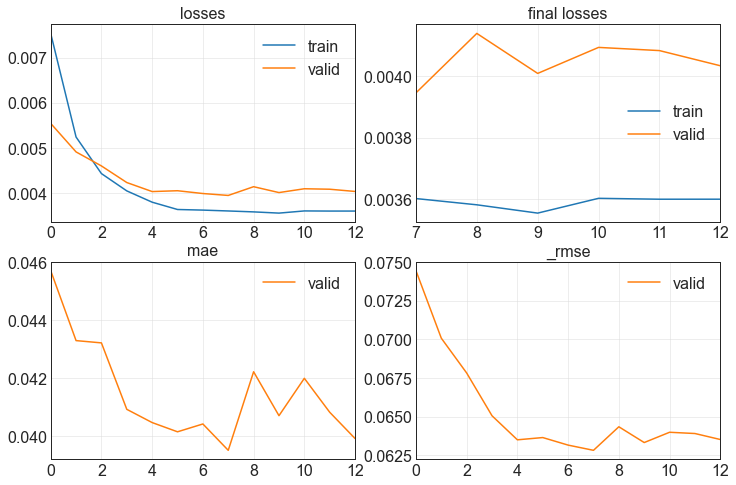

45.786670446395874                                                                                                     
[0.0035998926032334566, 0.004034209065139294, 0.03990287333726883, 0.06351541727781296]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 45%|█████████████████▌                     | 45/100 [6:50:21<5:30:00, 360.01s/trial, best loss: 0.0032448098063468933]

No improvement since epoch 29: early stopping                                                                          
 45%|█████████████████▌                     | 45/100 [7:12:42<5:30:00, 360.01s/trial, best loss: 0.0032448098063468933]

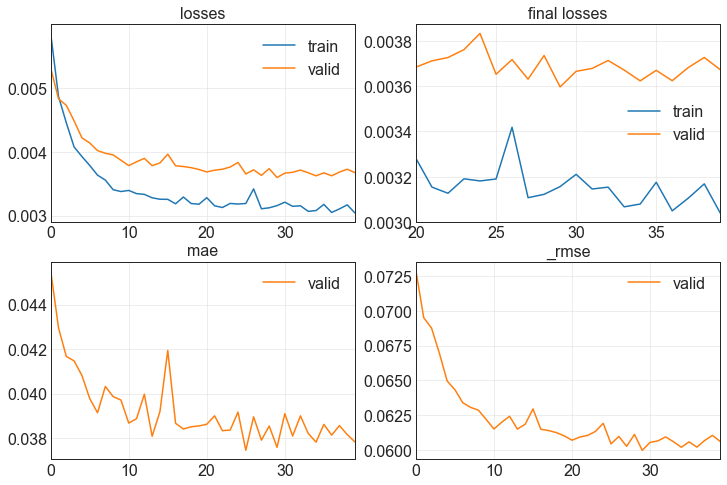

1341.9501893520355                                                                                                     
[0.0030393002089112997, 0.003673113649711013, 0.037817370146512985, 0.060606226325035095]                              
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 20, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 46%|█████████████████▉                     | 46/100 [7:12:47<9:50:23, 655.99s/trial, best loss: 0.0032448098063468933]

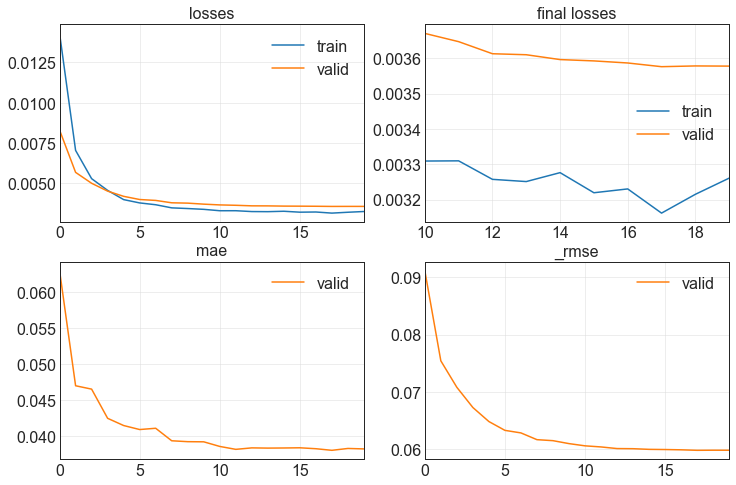

443.07103204727173                                                                                                     
[0.00326101784594357, 0.003577629802748561, 0.03816956281661987, 0.05981329455971718]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.5, 'epochs': 50, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 5}
TCN                                                                                                                    
 47%|██████████████████▎                    | 47/100 [7:20:15<8:44:17, 593.54s/trial, best loss: 0.0032448098063468933]

No improvement since epoch 2: early stopping                                                                           
 47%|██████████████████▎                    | 47/100 [7:21:26<8:44:17, 593.54s/trial, best loss: 0.0032448098063468933]

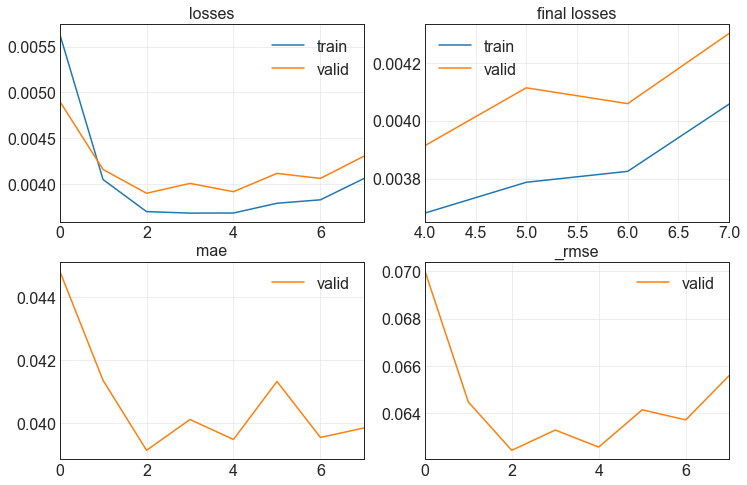

71.6538233757019                                                                                                       
[0.004057515878230333, 0.004301564302295446, 0.039839088916778564, 0.06558631360530853]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.1, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 48%|██████████████████▋                    | 48/100 [7:21:31<6:19:55, 438.37s/trial, best loss: 0.0032448098063468933]

No improvement since epoch 82: early stopping                                                                          
 48%|██████████████████▋                    | 48/100 [7:41:52<6:19:55, 438.37s/trial, best loss: 0.0032448098063468933]

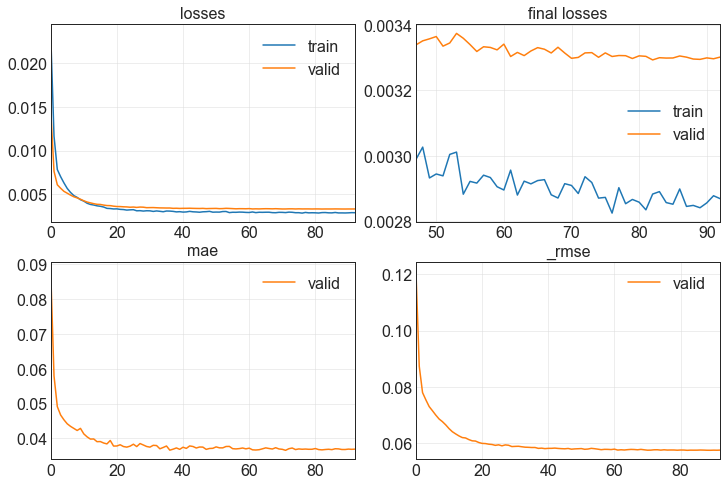

1220.7478804588318                                                                                                     
[0.002868850249797106, 0.003301723627373576, 0.03688624128699303, 0.05746062844991684]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 49%|███████████████████                    | 49/100 [7:41:57<9:33:18, 674.48s/trial, best loss: 0.0032448098063468933]

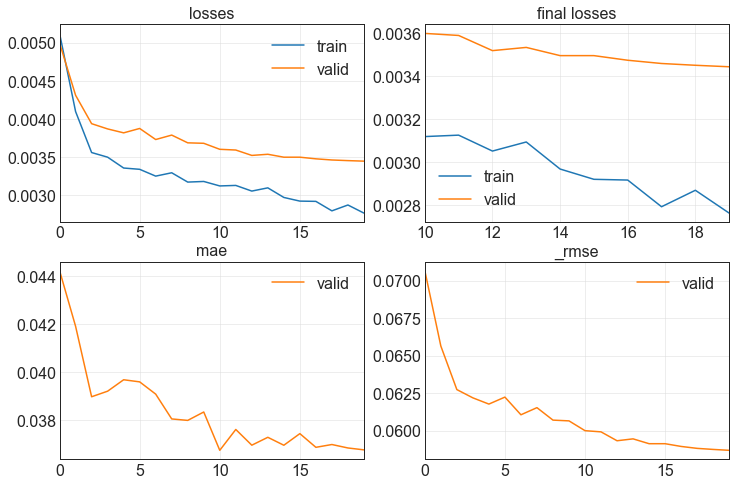

836.5931708812714                                                                                                      
[0.0027624787762761116, 0.003444445552304387, 0.03677023574709892, 0.05868940055370331]                                
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 5}
TCN                                                                                                                    
 50%|███████████████████                   | 50/100 [7:55:58<10:03:47, 724.54s/trial, best loss: 0.0032448098063468933]

No improvement since epoch 6: early stopping                                                                           
 50%|███████████████████                   | 50/100 [7:56:54<10:03:47, 724.54s/trial, best loss: 0.0032448098063468933]

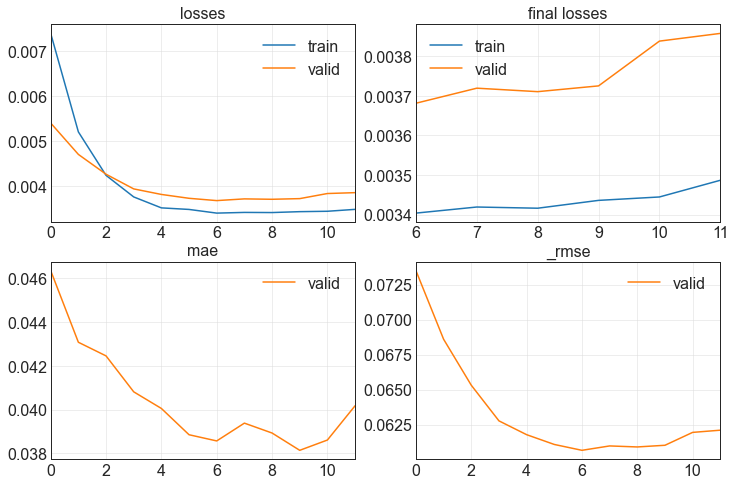

55.94444751739502                                                                                                      
[0.003486836329102516, 0.0038575746584683657, 0.04017481580376625, 0.06210938096046448]                                
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 51%|███████████████████▉                   | 51/100 [7:56:59<7:09:03, 525.37s/trial, best loss: 0.0032448098063468933]

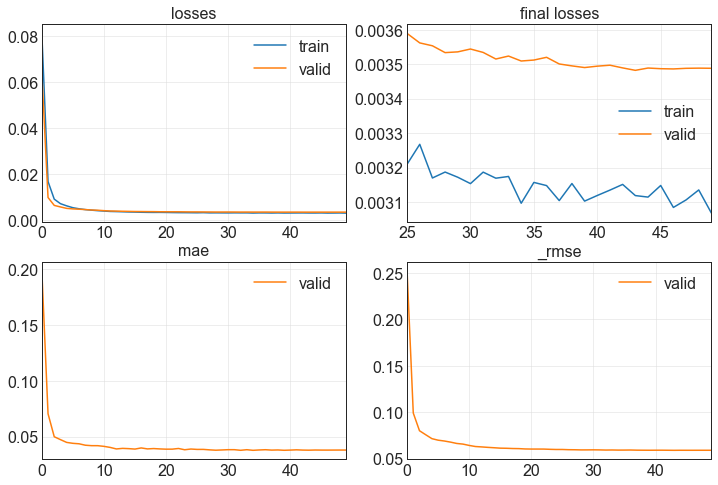

452.42690110206604                                                                                                     
[0.0030675933230668306, 0.003488263115286827, 0.03785259649157524, 0.05906151980161667]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 52%|████████████████████▎                  | 52/100 [8:04:36<6:43:55, 504.90s/trial, best loss: 0.0032448098063468933]

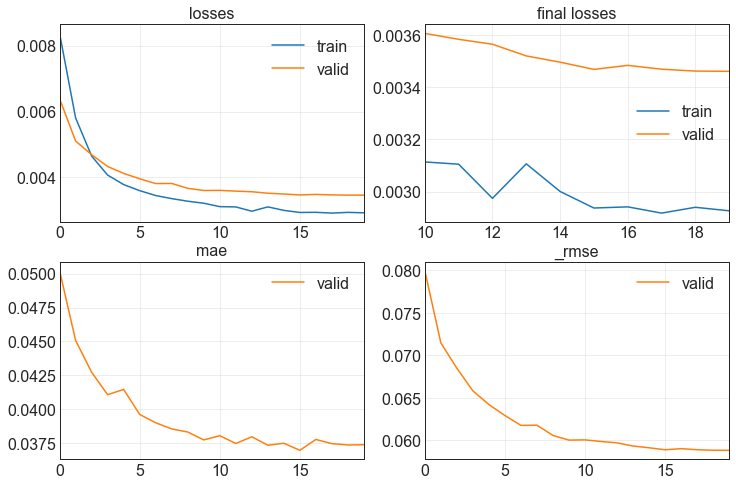

838.0596392154694                                                                                                      
[0.002925989218056202, 0.0034615788608789444, 0.037382908165454865, 0.05883520469069481]                               
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.1, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 5}
TCN                                                                                                                    
 53%|████████████████████▋                  | 53/100 [8:18:39<7:54:54, 606.26s/trial, best loss: 0.0032448098063468933]

No improvement since epoch 5: early stopping                                                                           
 53%|████████████████████▋                  | 53/100 [8:20:19<7:54:54, 606.26s/trial, best loss: 0.0032448098063468933]

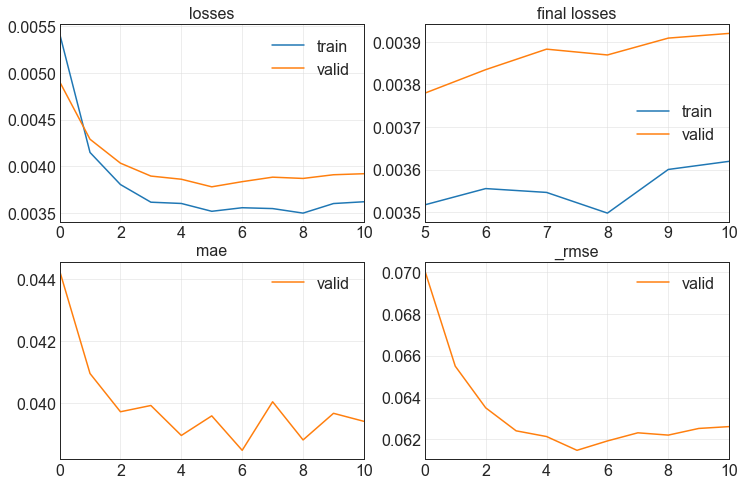

100.12596821784973                                                                                                     
[0.0036193174310028553, 0.003920099698007107, 0.03942073509097099, 0.0626106858253479]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 54%|█████████████████████                  | 54/100 [8:20:24<5:49:28, 455.84s/trial, best loss: 0.0032448098063468933]

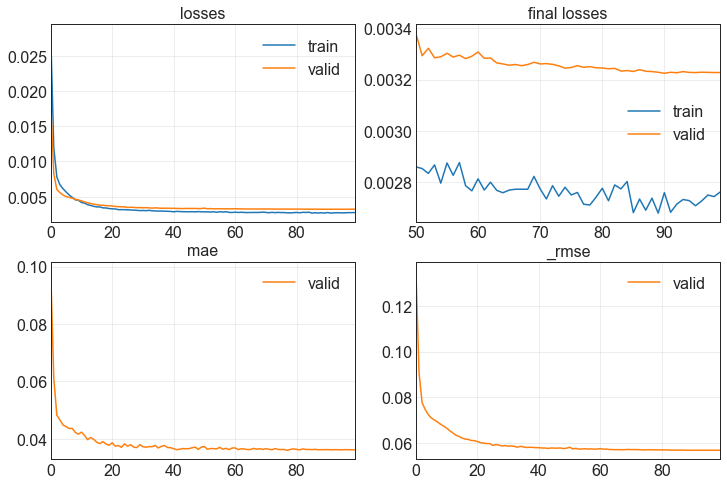

1286.9352984428406                                                                                                     
[0.0027616447769105434, 0.0032279372680932283, 0.03619539737701416, 0.056814927607774734]                              
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 55%|█████████████████████▍                 | 55/100 [8:41:55<8:49:55, 706.57s/trial, best loss: 0.0032279372680932283]

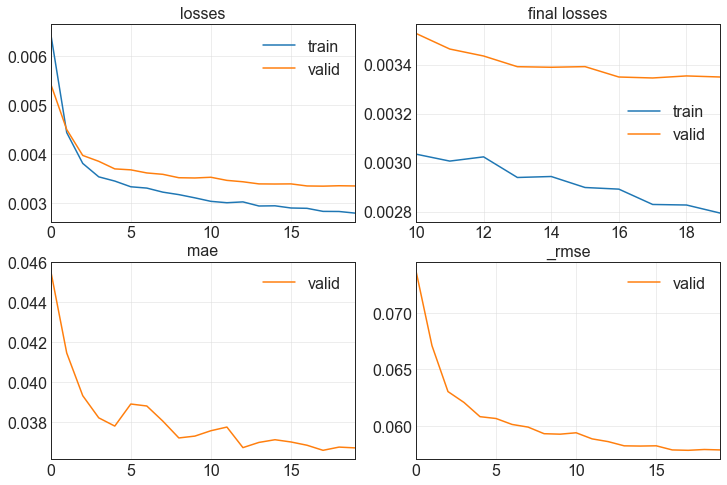

257.3526544570923                                                                                                      
[0.0027936669066548347, 0.0033491121139377356, 0.03673184663057327, 0.05787152051925659]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 56%|█████████████████████▊                 | 56/100 [8:46:17<7:00:22, 573.24s/trial, best loss: 0.0032279372680932283]

No improvement since epoch 52: early stopping                                                                          
 56%|█████████████████████▊                 | 56/100 [9:00:12<7:00:22, 573.24s/trial, best loss: 0.0032279372680932283]

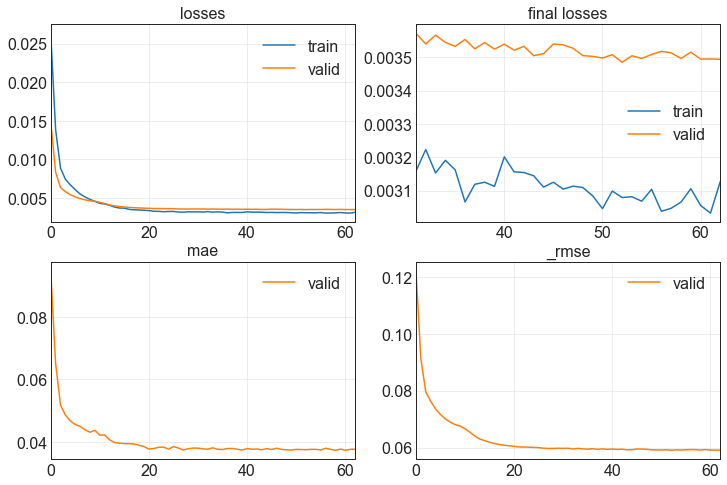

834.728296995163                                                                                                       
[0.0031273183412849903, 0.0034935702569782734, 0.03772334009408951, 0.05910642445087433]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 5}
TCN                                                                                                                    
 57%|██████████████████████▏                | 57/100 [9:00:17<7:48:03, 653.11s/trial, best loss: 0.0032279372680932283]

No improvement since epoch 2: early stopping                                                                           
 57%|██████████████████████▏                | 57/100 [9:02:03<7:48:03, 653.11s/trial, best loss: 0.0032279372680932283]

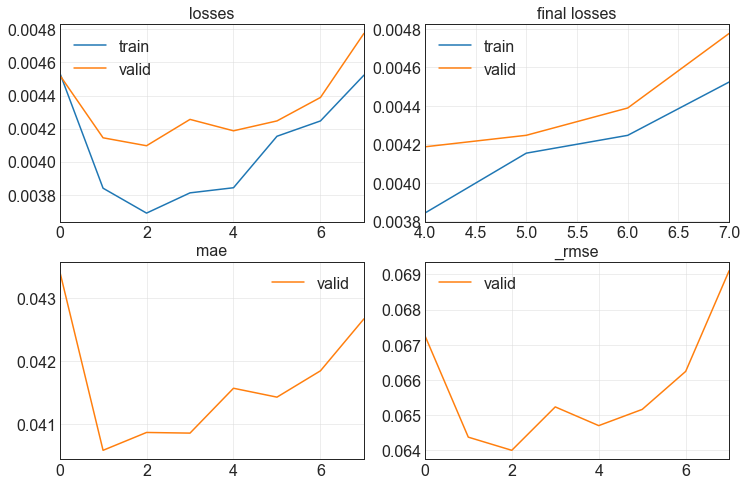

106.06445240974426                                                                                                     
[0.004523319657891989, 0.004775779787451029, 0.04266737401485443, 0.06910703331232071]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 58%|██████████████████████▌                | 58/100 [9:02:08<5:43:18, 490.44s/trial, best loss: 0.0032279372680932283]

No improvement since epoch 84: early stopping                                                                          
 58%|██████████████████████▌                | 58/100 [9:22:31<5:43:18, 490.44s/trial, best loss: 0.0032279372680932283]

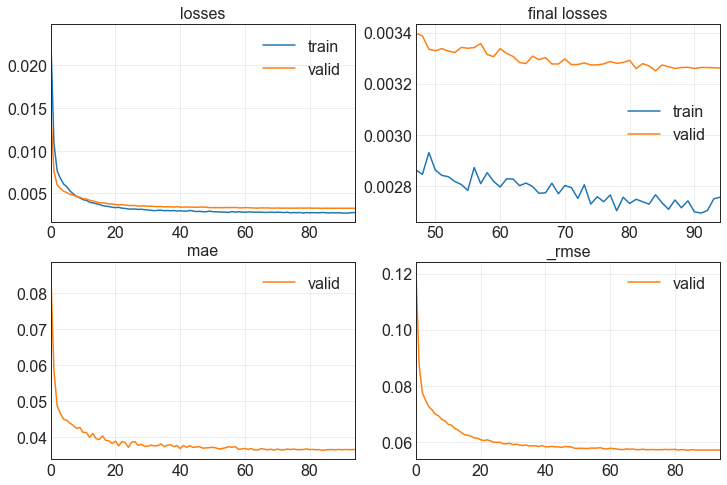

1223.839605808258                                                                                                      
[0.0027558724395930767, 0.003261068370193243, 0.03649722784757614, 0.05710576847195625]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.1, 'epochs': 20, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 59%|███████████████████████                | 59/100 [9:22:36<8:06:27, 711.89s/trial, best loss: 0.0032279372680932283]

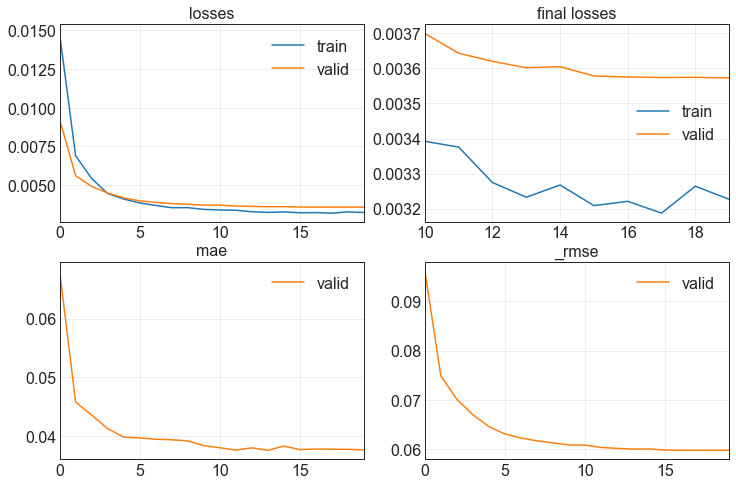

265.9975063800812                                                                                                      
[0.0032266927883028984, 0.003572744084522128, 0.03770378604531288, 0.05977242812514305]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 60%|███████████████████████▍               | 60/100 [9:27:07<6:26:22, 579.57s/trial, best loss: 0.0032279372680932283]

No improvement since epoch 51: early stopping                                                                          
 60%|███████████████████████▍               | 60/100 [9:40:26<6:26:22, 579.57s/trial, best loss: 0.0032279372680932283]

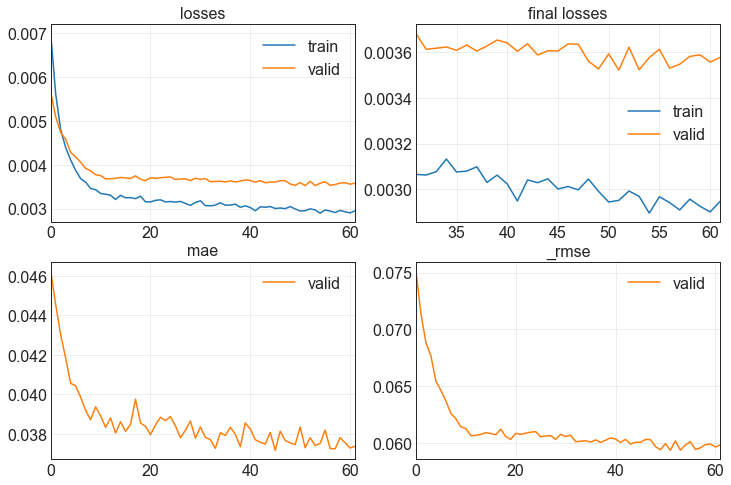

799.1285700798035                                                                                                      
[0.002948513487353921, 0.0035782107152044773, 0.03736099600791931, 0.05981815233826637]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 5}
TCN                                                                                                                    
 61%|███████████████████████▊               | 61/100 [9:40:31<7:00:27, 646.85s/trial, best loss: 0.0032279372680932283]

No improvement since epoch 41: early stopping                                                                          
 61%|███████████████████████▊               | 61/100 [9:50:36<7:00:27, 646.85s/trial, best loss: 0.0032279372680932283]

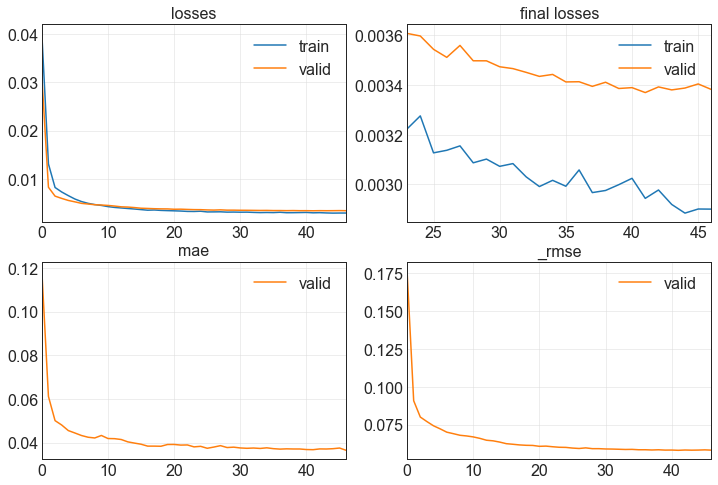

605.4907939434052                                                                                                      
[0.0029007201083004475, 0.003382402937859297, 0.036472905427217484, 0.058158427476882935]                              
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 62%|████████████████████████▏              | 62/100 [9:50:41<6:42:42, 635.86s/trial, best loss: 0.0032279372680932283]

No improvement since epoch 44: early stopping                                                                          
 62%|███████████████████████▌              | 62/100 [10:02:52<6:42:42, 635.86s/trial, best loss: 0.0032279372680932283]

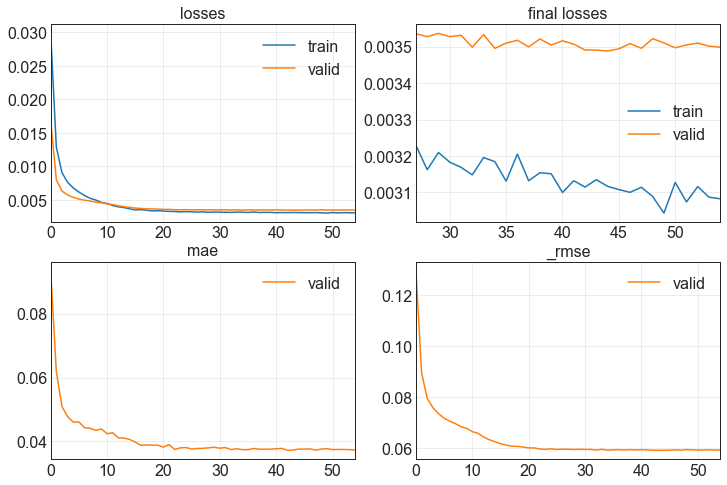

731.1545958518982                                                                                                      
[0.0030826933216303587, 0.0034984834492206573, 0.03733556345105171, 0.05914797633886337]                               
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 50, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 63%|███████████████████████▉              | 63/100 [10:02:57<6:50:37, 665.88s/trial, best loss: 0.0032279372680932283]

No improvement since epoch 1: early stopping                                                                           
 63%|███████████████████████▉              | 63/100 [10:08:00<6:50:37, 665.88s/trial, best loss: 0.0032279372680932283]

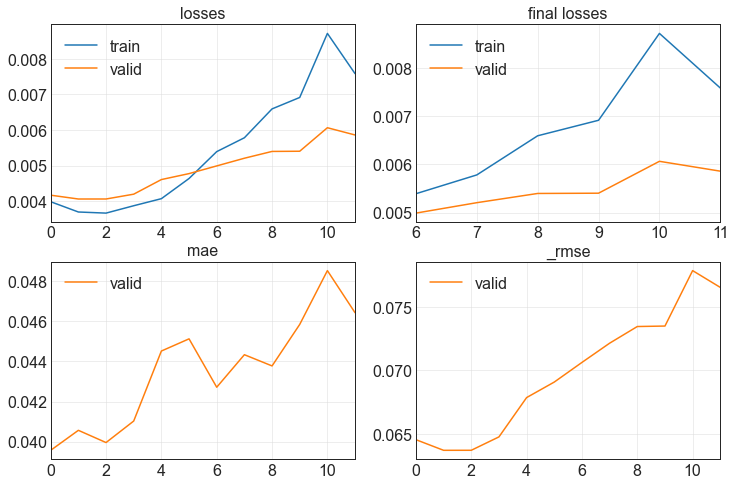

302.8305160999298                                                                                                      
[0.007579877506941557, 0.005857998970896006, 0.04642000421881676, 0.07653756439685822]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 64%|████████████████████████▎             | 64/100 [10:08:05<5:35:02, 558.40s/trial, best loss: 0.0032279372680932283]

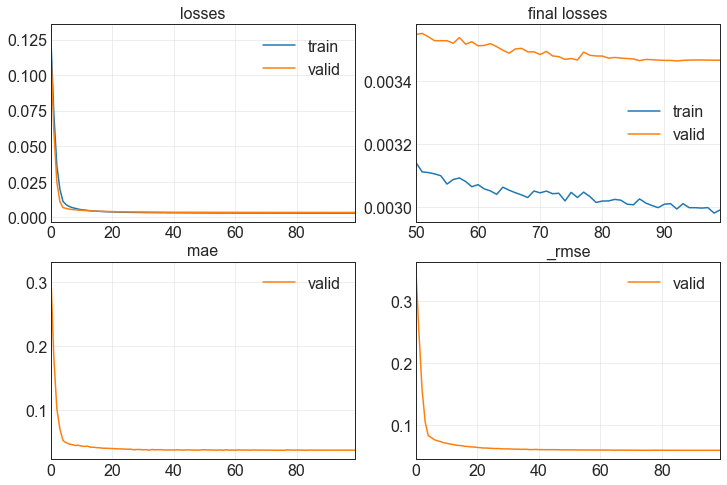

595.0563499927521                                                                                                      
[0.00299167912453413, 0.003466386580839753, 0.03762334585189819, 0.058876026421785355]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 65%|████████████████████████▋             | 65/100 [10:18:05<5:32:58, 570.81s/trial, best loss: 0.0032279372680932283]

No improvement since epoch 86: early stopping                                                                          
 65%|████████████████████████▋             | 65/100 [10:38:55<5:32:58, 570.81s/trial, best loss: 0.0032279372680932283]

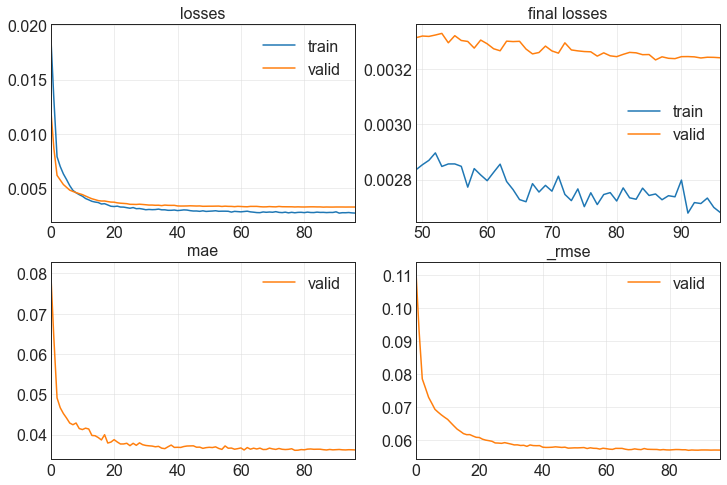

1250.7155616283417                                                                                                     
[0.0026812395080924034, 0.0032395829912275076, 0.036215733736753464, 0.056917332112789154]                             
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 66%|█████████████████████████             | 66/100 [10:39:00<7:19:50, 776.18s/trial, best loss: 0.0032279372680932283]

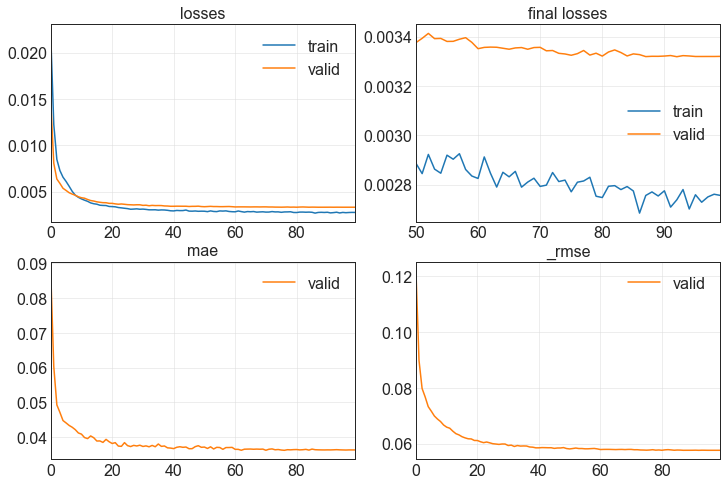

1324.3154911994934                                                                                                     
[0.0027559439186006784, 0.003319856943562627, 0.036375321447849274, 0.05761820450425148]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 67%|█████████████████████████▍            | 67/100 [11:01:09<8:38:07, 942.05s/trial, best loss: 0.0032279372680932283]

No improvement since epoch 69: early stopping                                                                          
 67%|█████████████████████████▍            | 67/100 [11:19:08<8:38:07, 942.05s/trial, best loss: 0.0032279372680932283]

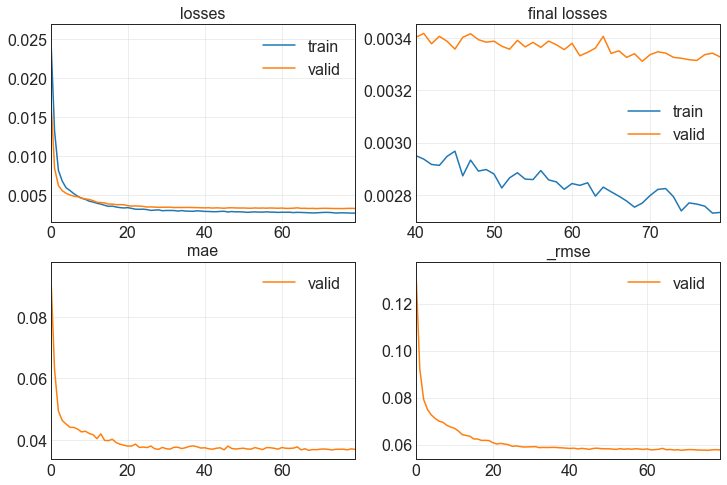

1079.2815856933594                                                                                                     
[0.002733518835157156, 0.003326390404254198, 0.03688801825046539, 0.057674869894981384]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 68%|█████████████████████████▊            | 68/100 [11:19:13<8:45:09, 984.66s/trial, best loss: 0.0032279372680932283]

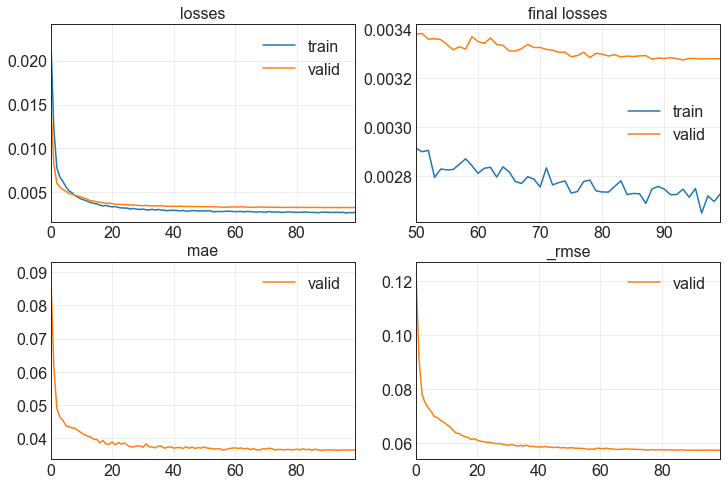

1312.719598531723                                                                                                      
[0.0027263727970421314, 0.0032802820205688477, 0.03641956299543381, 0.057273752987384796]                              
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 69%|█████████████████████████▌           | 69/100 [11:41:11<9:20:21, 1084.57s/trial, best loss: 0.0032279372680932283]

No improvement since epoch 85: early stopping                                                                          
 69%|█████████████████████████▌           | 69/100 [12:02:04<9:20:21, 1084.57s/trial, best loss: 0.0032279372680932283]

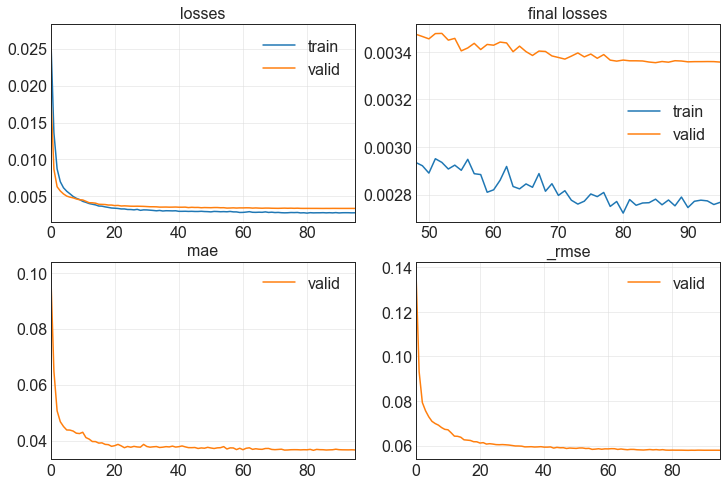

1253.2704858779907                                                                                                     
[0.0027679824270308018, 0.003356616711243987, 0.03663572669029236, 0.057936329394578934]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 70%|█████████████████████████▉           | 70/100 [12:02:09<9:28:18, 1136.62s/trial, best loss: 0.0032279372680932283]

No improvement since epoch 81: early stopping                                                                          
 70%|█████████████████████████▉           | 70/100 [12:22:46<9:28:18, 1136.62s/trial, best loss: 0.0032279372680932283]

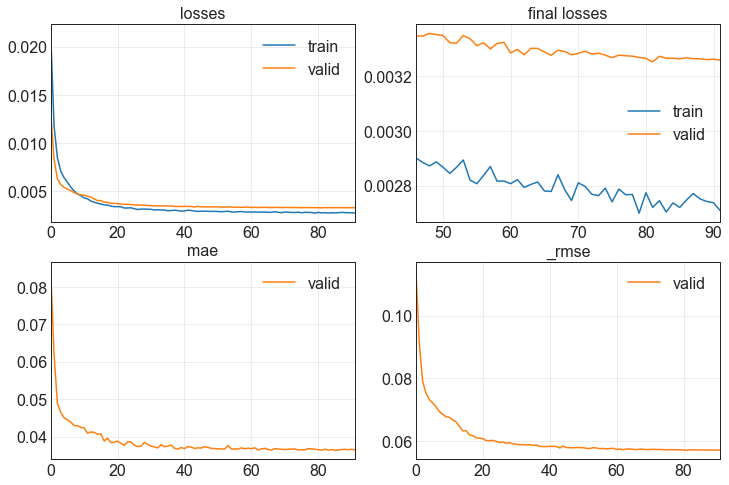

1237.277104139328                                                                                                      
[0.0027087691705673933, 0.0032571163028478622, 0.03641286492347717, 0.05707116052508354]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 71%|██████████████████████████▎          | 71/100 [12:22:51<9:24:42, 1168.35s/trial, best loss: 0.0032279372680932283]

No improvement since epoch 61: early stopping                                                                          
 71%|██████████████████████████▎          | 71/100 [12:38:30<9:24:42, 1168.35s/trial, best loss: 0.0032279372680932283]

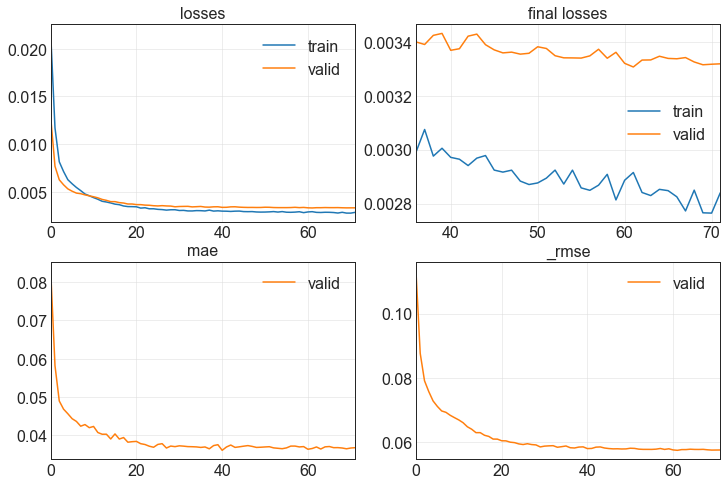

938.7175149917603                                                                                                      
[0.0028404914774000645, 0.003318414092063904, 0.03681279718875885, 0.05760568380355835]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 72%|██████████████████████████▋          | 72/100 [12:38:35<8:33:45, 1100.91s/trial, best loss: 0.0032279372680932283]

No improvement since epoch 65: early stopping                                                                          
 72%|██████████████████████████▋          | 72/100 [12:54:51<8:33:45, 1100.91s/trial, best loss: 0.0032279372680932283]

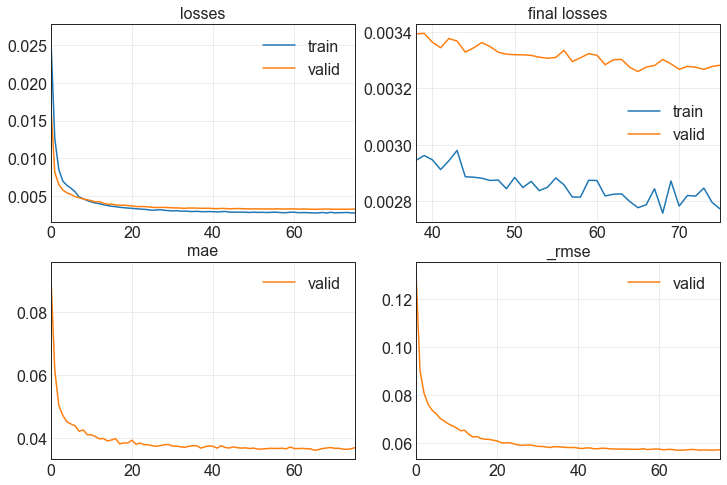

976.7780928611755                                                                                                      
[0.0027724013198167086, 0.003282279474660754, 0.036813460290431976, 0.057291179895401]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 73%|███████████████████████████          | 73/100 [12:54:56<7:59:17, 1065.10s/trial, best loss: 0.0032279372680932283]

No improvement since epoch 72: early stopping                                                                          
 73%|███████████████████████████          | 73/100 [13:12:50<7:59:17, 1065.10s/trial, best loss: 0.0032279372680932283]

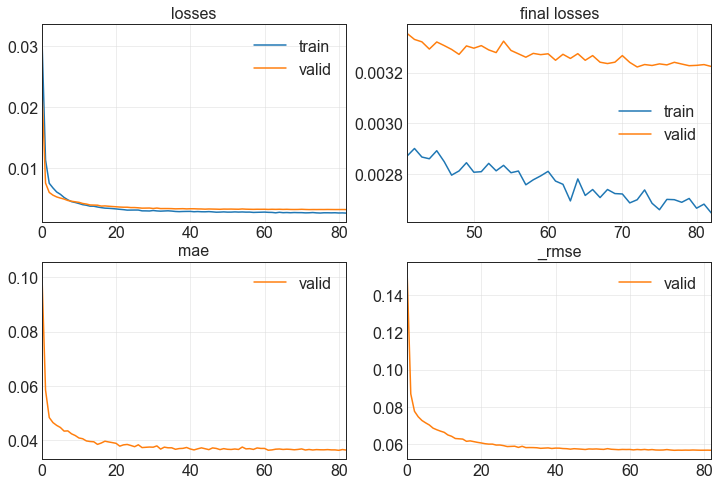

1073.6759634017944                                                                                                     
[0.002645387314260006, 0.0032244164030998945, 0.03629637137055397, 0.056783951818943024]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 74%|███████████████████████████▍         | 74/100 [13:12:55<7:43:17, 1069.12s/trial, best loss: 0.0032244164030998945]

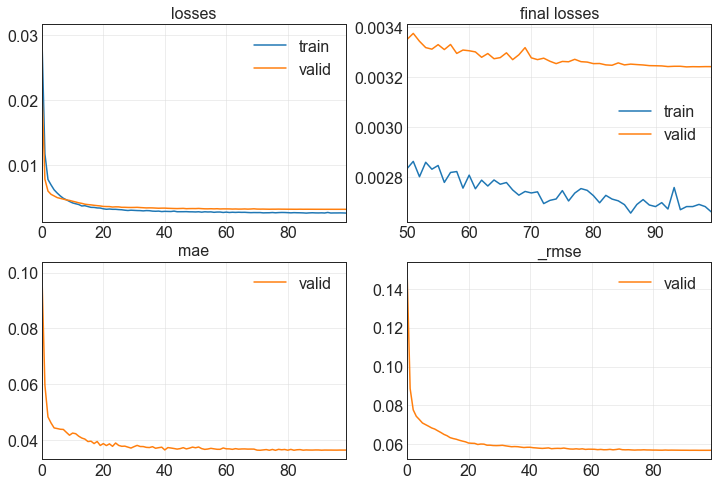

1291.9099645614624                                                                                                     
[0.002661548089236021, 0.003241379279643297, 0.03630324825644493, 0.05693311616778374]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 75%|███████████████████████████▊         | 75/100 [13:34:32<7:53:54, 1137.39s/trial, best loss: 0.0032244164030998945]

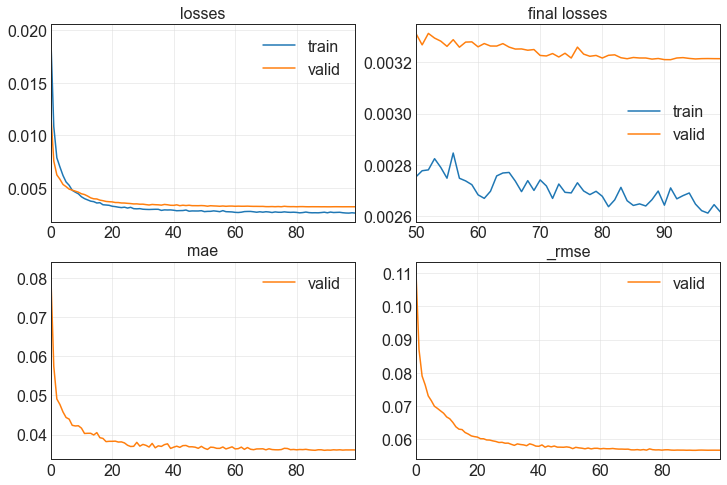

1292.3269267082214                                                                                                     
[0.002616242738440633, 0.003214011201635003, 0.0360860712826252, 0.05669224262237549]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.1, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 76%|████████████████████████████▉         | 76/100 [13:56:09<7:54:07, 1185.30s/trial, best loss: 0.003214011201635003]

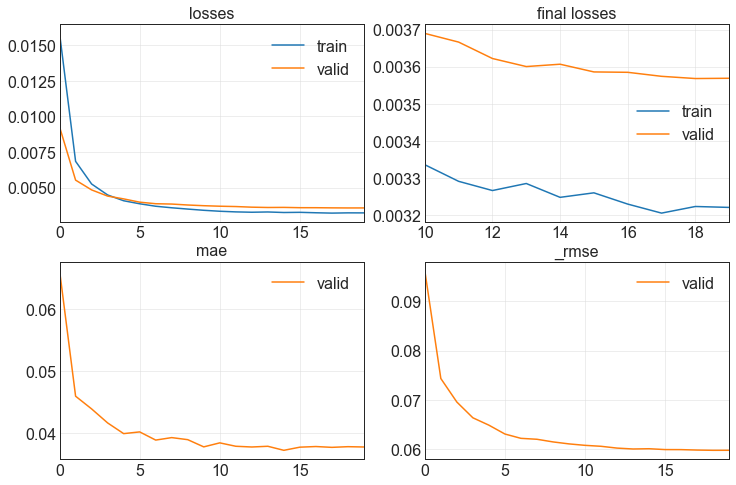

266.15370321273804                                                                                                     
[0.003220814047381282, 0.003568860236555338, 0.03773602843284607, 0.059739939868450165]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 77%|██████████████████████████████         | 77/100 [14:00:40<5:49:13, 911.03s/trial, best loss: 0.003214011201635003]

No improvement since epoch 55: early stopping                                                                          
 77%|██████████████████████████████         | 77/100 [14:14:51<5:49:13, 911.03s/trial, best loss: 0.003214011201635003]

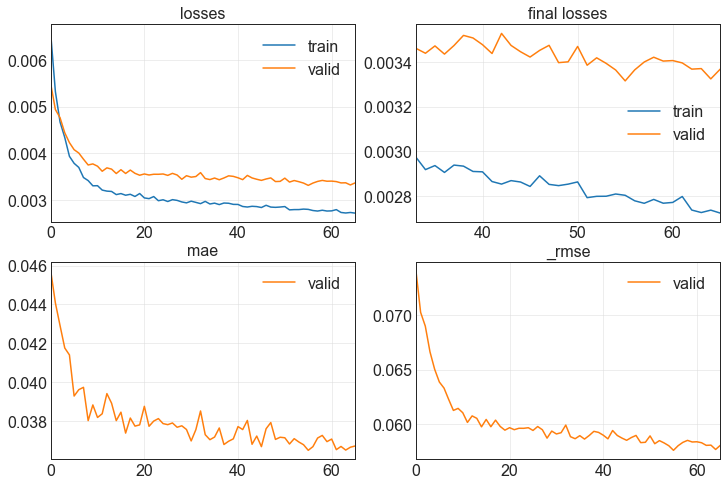

851.7929751873016                                                                                                      
[0.0027221795171499252, 0.003368652891367674, 0.036712344735860825, 0.05804010108113289]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 78%|██████████████████████████████▍        | 78/100 [14:14:56<5:28:02, 894.67s/trial, best loss: 0.003214011201635003]

No improvement since epoch 67: early stopping                                                                          
 78%|██████████████████████████████▍        | 78/100 [14:31:43<5:28:02, 894.67s/trial, best loss: 0.003214011201635003]

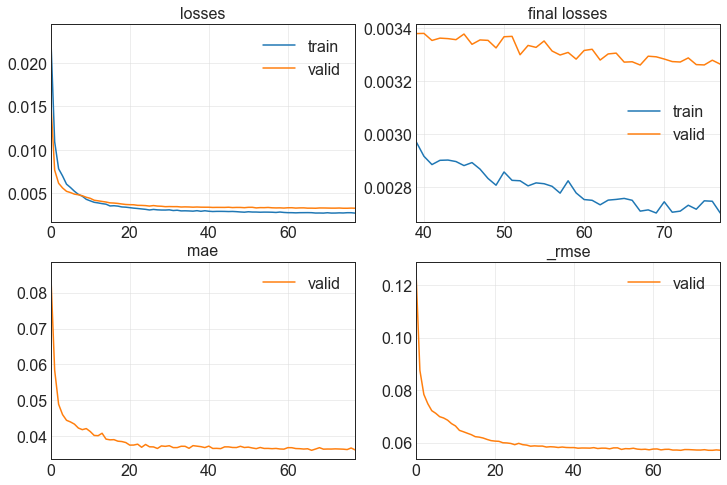

1007.3005282878876                                                                                                     
[0.0027015029918402433, 0.0032641200814396143, 0.036279093474149704, 0.05713248625397682]                              
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 5}
TCN                                                                                                                    
 79%|██████████████████████████████▊        | 79/100 [14:31:48<5:25:27, 929.90s/trial, best loss: 0.003214011201635003]

No improvement since epoch 34: early stopping                                                                          
 79%|██████████████████████████████▊        | 79/100 [14:40:40<5:25:27, 929.90s/trial, best loss: 0.003214011201635003]

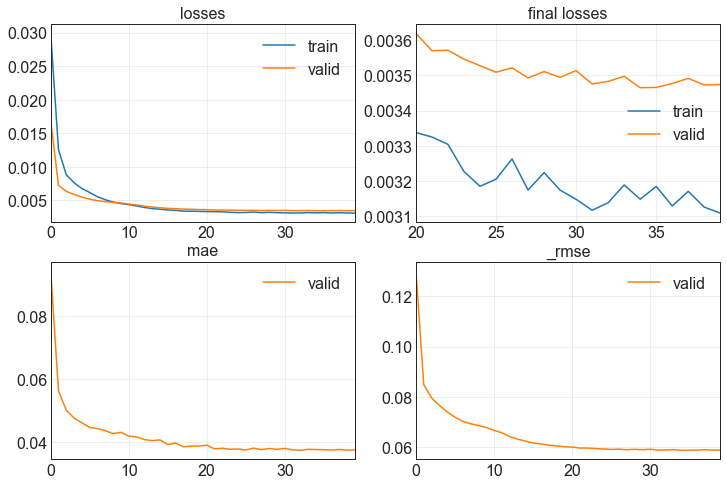

531.7750177383423                                                                                                      
[0.003108465112745762, 0.0034740755800157785, 0.0374918095767498, 0.05894129350781441]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 80%|███████████████████████████████▏       | 80/100 [14:40:45<4:30:37, 811.89s/trial, best loss: 0.003214011201635003]

No improvement since epoch 4: early stopping                                                                           
 80%|███████████████████████████████▏       | 80/100 [14:44:04<4:30:37, 811.89s/trial, best loss: 0.003214011201635003]

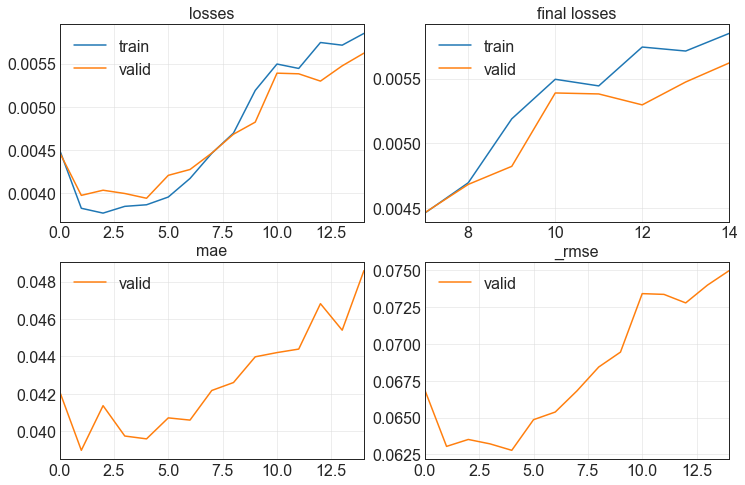

199.79485487937927                                                                                                     
[0.005850240122526884, 0.00562163395807147, 0.04858381673693657, 0.07497755438089371]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 81%|███████████████████████████████▌       | 81/100 [14:44:09<3:19:23, 629.67s/trial, best loss: 0.003214011201635003]

No improvement since epoch 82: early stopping                                                                          
 81%|███████████████████████████████▌       | 81/100 [15:23:23<3:19:23, 629.67s/trial, best loss: 0.003214011201635003]

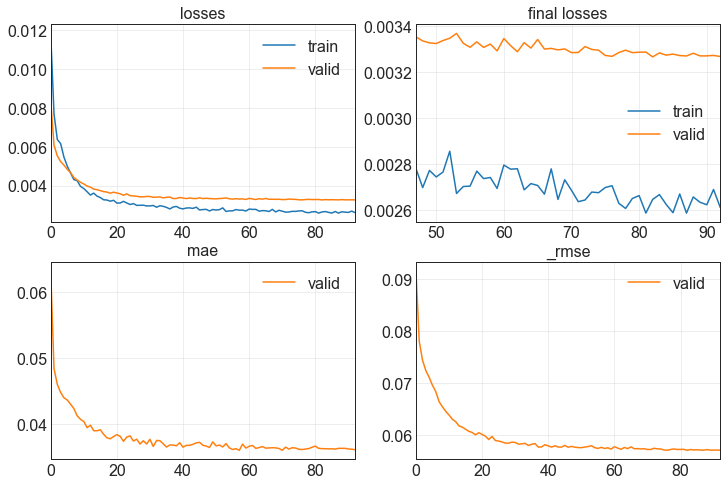

2354.3408439159393                                                                                                     
[0.0026114180218428373, 0.0032680220901966095, 0.03612356632947922, 0.05716660991311073]                               
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.1, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 82%|███████████████████████████████▏      | 82/100 [15:23:29<5:44:32, 1148.49s/trial, best loss: 0.003214011201635003]

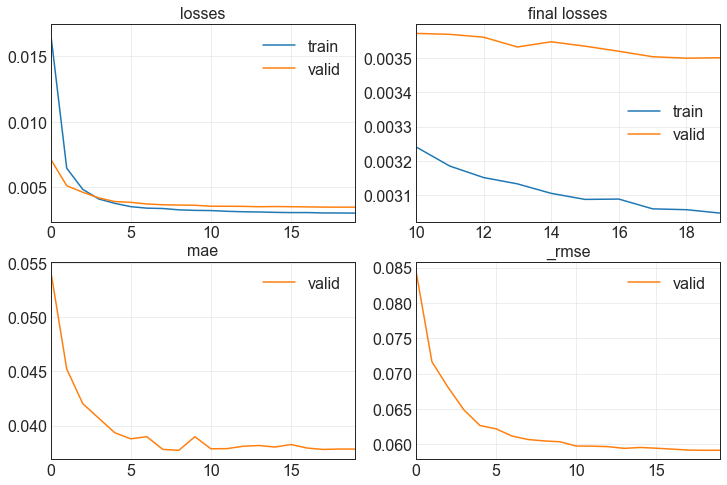

118.92458248138428                                                                                                     
[0.0030470704659819603, 0.003500918159261346, 0.03783297911286354, 0.059168554842472076]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 5}
TCN                                                                                                                    
 83%|████████████████████████████████▎      | 83/100 [15:25:32<3:58:18, 841.09s/trial, best loss: 0.003214011201635003]

No improvement since epoch 44: early stopping                                                                          
 83%|████████████████████████████████▎      | 83/100 [15:36:19<3:58:18, 841.09s/trial, best loss: 0.003214011201635003]

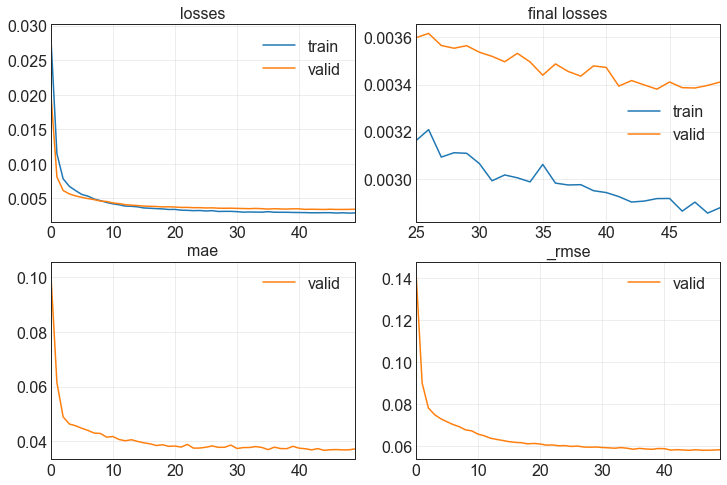

646.8987655639648                                                                                                      
[0.0028774195816367865, 0.0034108092077076435, 0.0372358039021492, 0.058402128517627716]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 84%|████████████████████████████████▊      | 84/100 [15:36:24<3:29:07, 784.25s/trial, best loss: 0.003214011201635003]

No improvement since epoch 80: early stopping                                                                          
 84%|████████████████████████████████▊      | 84/100 [15:56:02<3:29:07, 784.25s/trial, best loss: 0.003214011201635003]

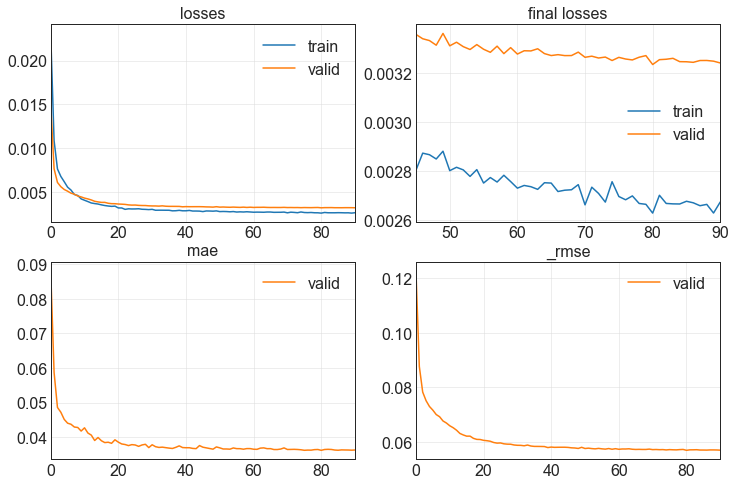

1179.1198437213898                                                                                                     
[0.002675409195944667, 0.0032396127935498953, 0.03631071001291275, 0.056917592883110046]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 85%|█████████████████████████████████▏     | 85/100 [15:56:08<3:46:01, 904.13s/trial, best loss: 0.003214011201635003]

No improvement since epoch 1: early stopping                                                                           
 85%|█████████████████████████████████▏     | 85/100 [15:58:48<3:46:01, 904.13s/trial, best loss: 0.003214011201635003]

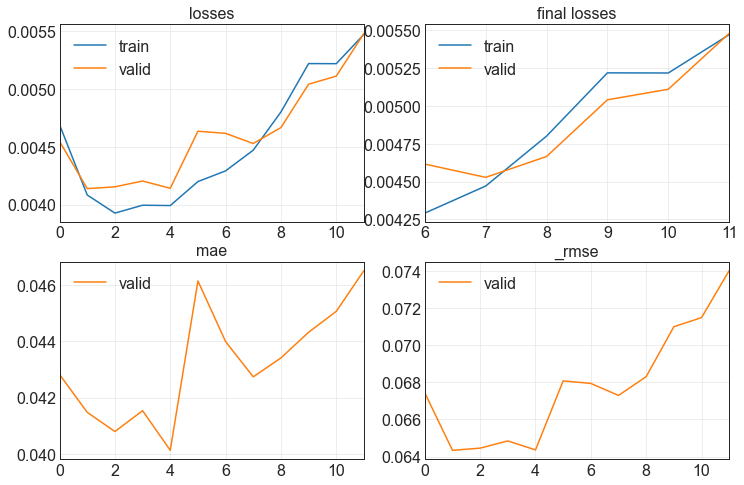

160.96502947807312                                                                                                     
[0.005470504984259605, 0.005478904116898775, 0.04651624709367752, 0.07401961833238602]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 86%|█████████████████████████████████▌     | 86/100 [15:58:53<2:39:16, 682.61s/trial, best loss: 0.003214011201635003]

No improvement since epoch 42: early stopping                                                                          
 86%|█████████████████████████████████▌     | 86/100 [16:37:04<2:39:16, 682.61s/trial, best loss: 0.003214011201635003]

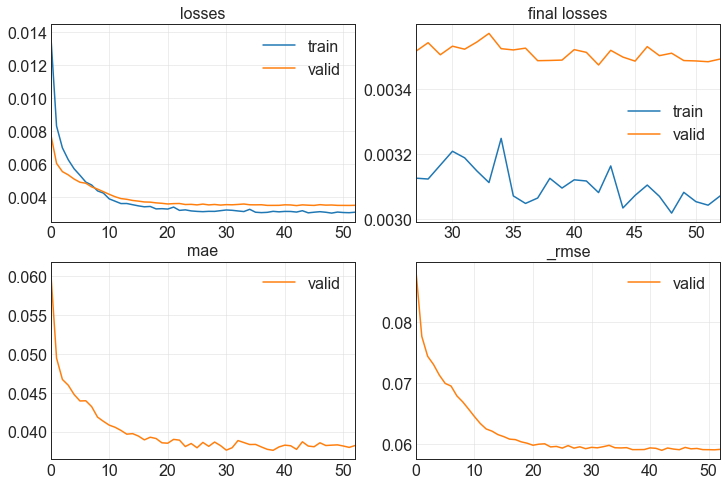

2291.2882878780365                                                                                                     
[0.0030717309564352036, 0.0034917709417641163, 0.038222428411245346, 0.059091195464134216]                             
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 87%|█████████████████████████████████     | 87/100 [16:37:09<4:12:45, 1166.61s/trial, best loss: 0.003214011201635003]

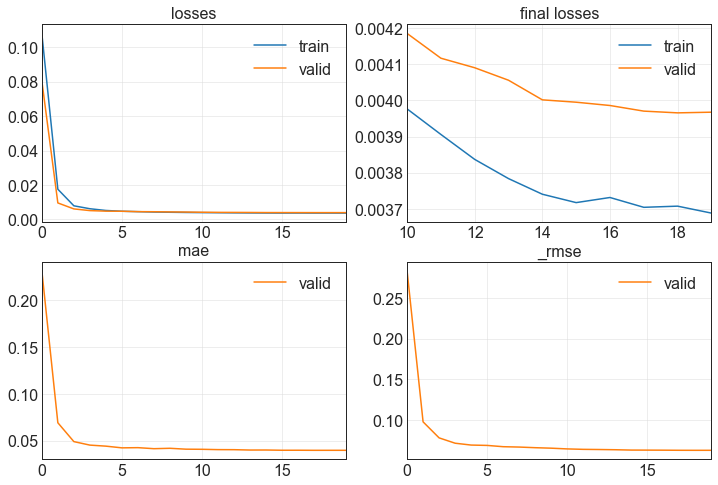

68.59245753288269                                                                                                      
[0.0036882595159113407, 0.003967334516346455, 0.039523523300886154, 0.06298679113388062]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 5}
TCN                                                                                                                    
 88%|██████████████████████████████████▎    | 88/100 [16:38:23<2:47:43, 838.63s/trial, best loss: 0.003214011201635003]

No improvement since epoch 17: early stopping                                                                          
 88%|██████████████████████████████████▎    | 88/100 [16:43:20<2:47:43, 838.63s/trial, best loss: 0.003214011201635003]

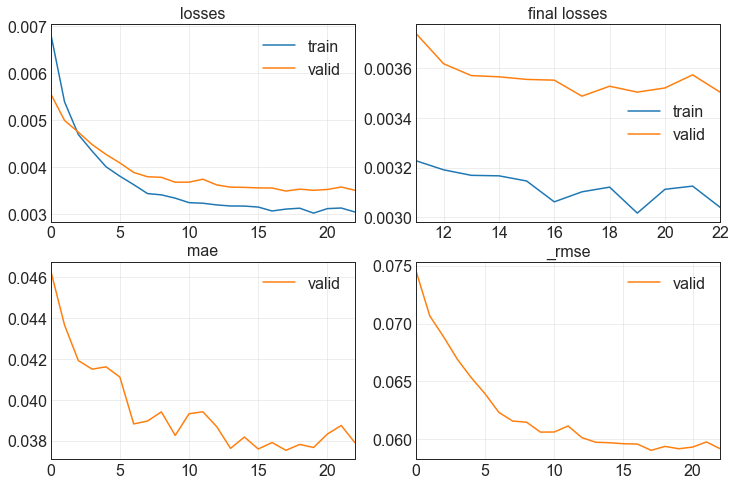

297.49622678756714                                                                                                     
[0.0030396846123039722, 0.0035031524021178484, 0.0378946028649807, 0.05918743088841438]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.1, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 89%|██████████████████████████████████▋    | 89/100 [16:43:25<2:04:14, 677.70s/trial, best loss: 0.003214011201635003]

No improvement since epoch 45: early stopping                                                                          
 89%|██████████████████████████████████▋    | 89/100 [16:55:51<2:04:14, 677.70s/trial, best loss: 0.003214011201635003]

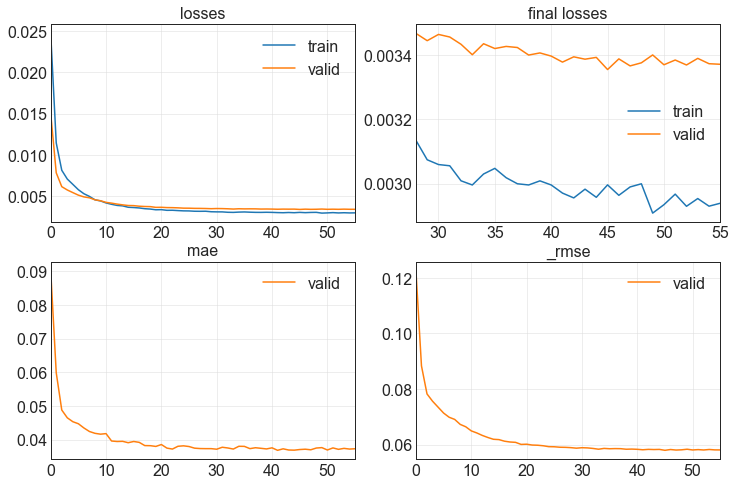

746.1748449802399                                                                                                      
[0.002939260797575116, 0.0033716147299855947, 0.037305597215890884, 0.05806560069322586]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 90%|███████████████████████████████████    | 90/100 [16:55:56<1:56:36, 699.64s/trial, best loss: 0.003214011201635003]

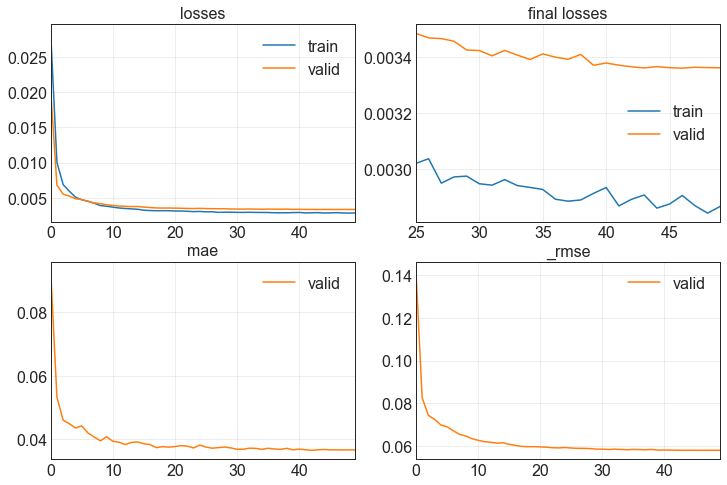

647.5146870613098                                                                                                      
[0.002866832073777914, 0.003360722679644823, 0.03673380985856056, 0.05797174945473671]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 91%|███████████████████████████████████▍   | 91/100 [17:06:48<1:42:48, 685.42s/trial, best loss: 0.003214011201635003]

No improvement since epoch 4: early stopping                                                                           
 91%|███████████████████████████████████▍   | 91/100 [17:17:16<1:42:48, 685.42s/trial, best loss: 0.003214011201635003]

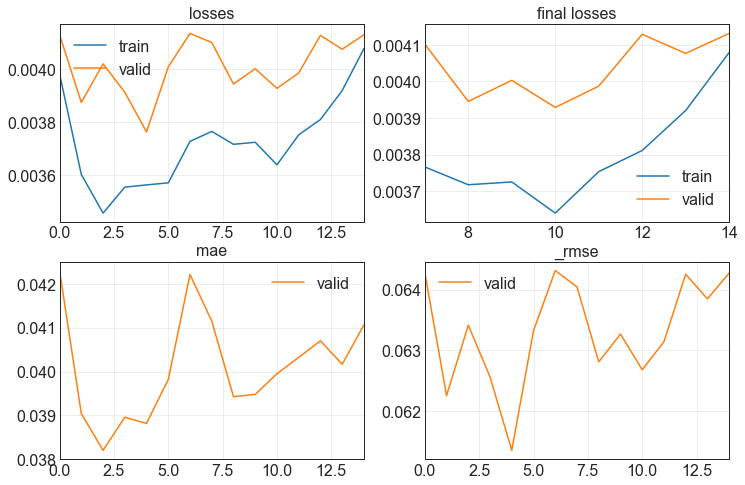

628.0492131710052                                                                                                      
[0.004078936763107777, 0.004131114576011896, 0.041064806282520294, 0.06427373737096786]                                
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 5}
TCN                                                                                                                    
 92%|███████████████████████████████████▉   | 92/100 [17:17:21<1:29:17, 669.63s/trial, best loss: 0.003214011201635003]

No improvement since epoch 45: early stopping                                                                          
 92%|███████████████████████████████████▉   | 92/100 [17:20:21<1:29:17, 669.63s/trial, best loss: 0.003214011201635003]

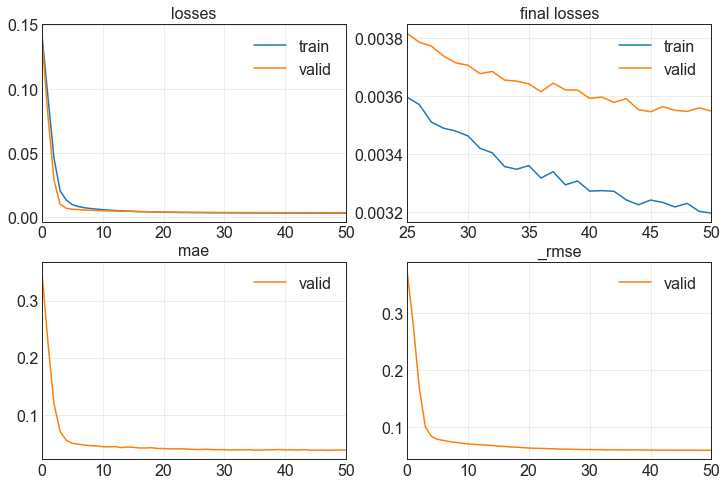

180.81300902366638                                                                                                     
[0.003195206169039011, 0.0035480118822306395, 0.038154486566782, 0.05956519395112991]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 93%|████████████████████████████████████▎  | 93/100 [17:20:26<1:01:10, 524.39s/trial, best loss: 0.003214011201635003]

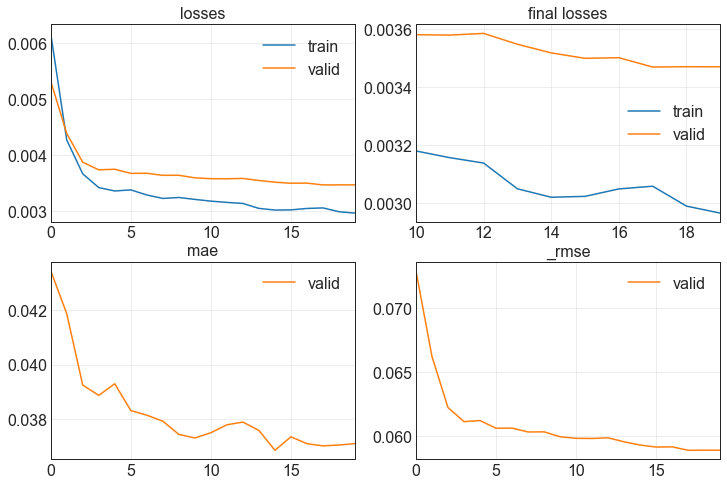

266.9162232875824                                                                                                      
[0.002965603256598115, 0.0034694864880293608, 0.037097226828336716, 0.05890236049890518]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 94%|██████████████████████████████████████▌  | 94/100 [17:24:58<44:51, 448.56s/trial, best loss: 0.003214011201635003]

No improvement since epoch 76: early stopping                                                                          
 94%|██████████████████████████████████████▌  | 94/100 [17:43:53<44:51, 448.56s/trial, best loss: 0.003214011201635003]

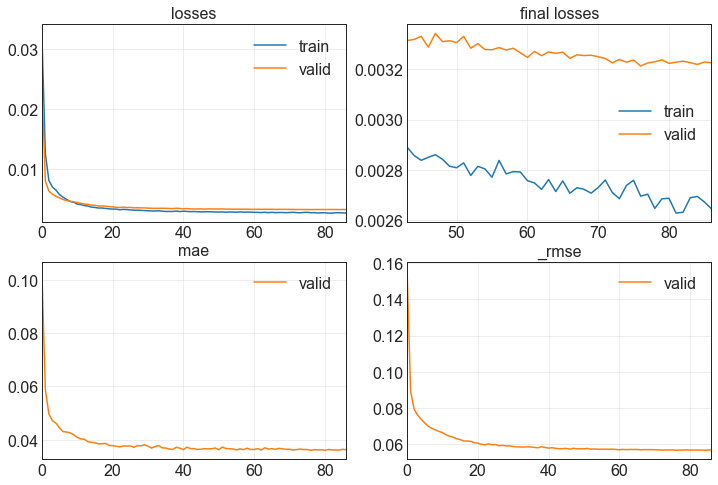

1135.3794257640839                                                                                                     
[0.002645601984113455, 0.003225630382075906, 0.0363154336810112, 0.056794628500938416]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.1, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 95%|██████████████████████████████████████▉  | 95/100 [17:43:58<54:40, 656.00s/trial, best loss: 0.003214011201635003]

No improvement since epoch 78: early stopping                                                                          
 95%|██████████████████████████████████████▉  | 95/100 [18:17:15<54:40, 656.00s/trial, best loss: 0.003214011201635003]

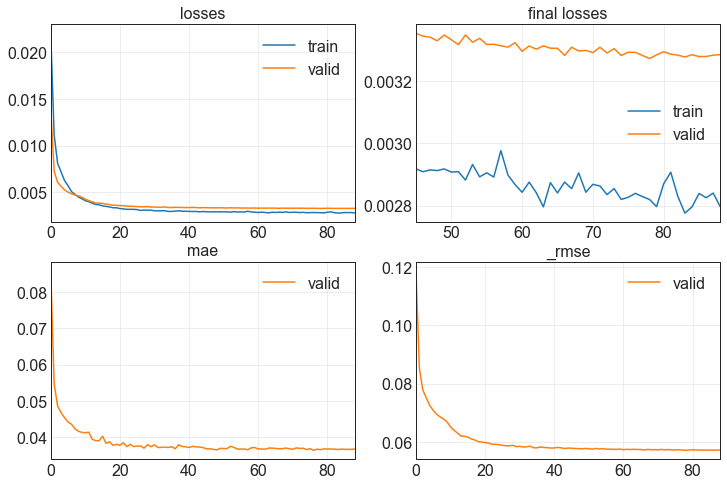

1997.4073848724365                                                                                                     
[0.002796011045575142, 0.0032856601756066084, 0.03670838102698326, 0.05732067674398422]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 96%|████████████████████████████████████▍ | 96/100 [18:17:20<1:10:39, 1059.86s/trial, best loss: 0.003214011201635003]

No improvement since epoch 3: early stopping                                                                           
 96%|████████████████████████████████████▍ | 96/100 [18:23:12<1:10:39, 1059.86s/trial, best loss: 0.003214011201635003]

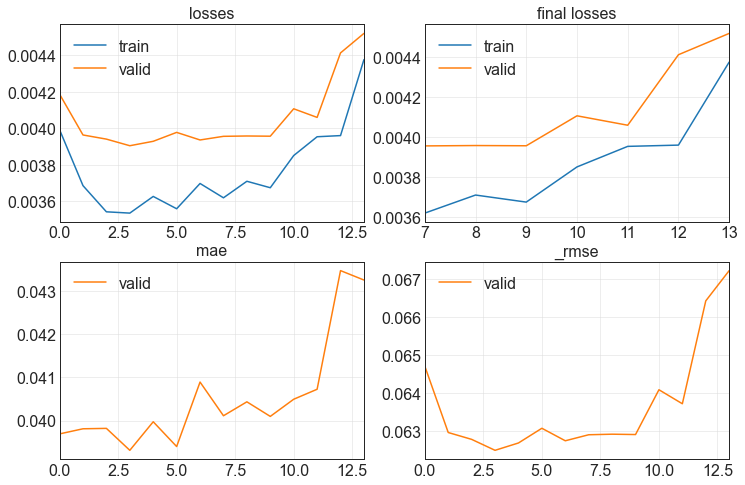

352.6921684741974                                                                                                      
[0.00437668664380908, 0.004520472604781389, 0.04325433075428009, 0.06723445653915405]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 5}
TCN                                                                                                                    
 97%|███████████████████████████████████████▊ | 97/100 [18:23:18<42:27, 849.14s/trial, best loss: 0.003214011201635003]

No improvement since epoch 44: early stopping                                                                          
 97%|███████████████████████████████████████▊ | 97/100 [18:34:04<42:27, 849.14s/trial, best loss: 0.003214011201635003]

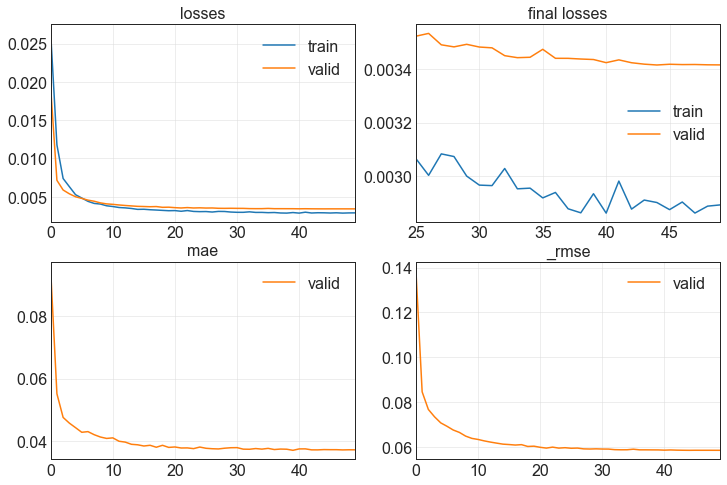

647.1413600444794                                                                                                      
[0.00289272703230381, 0.003415521467104554, 0.03712675720453262, 0.05844246596097946]                                  
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 98%|████████████████████████████████████████▏| 98/100 [18:34:09<26:19, 789.96s/trial, best loss: 0.003214011201635003]

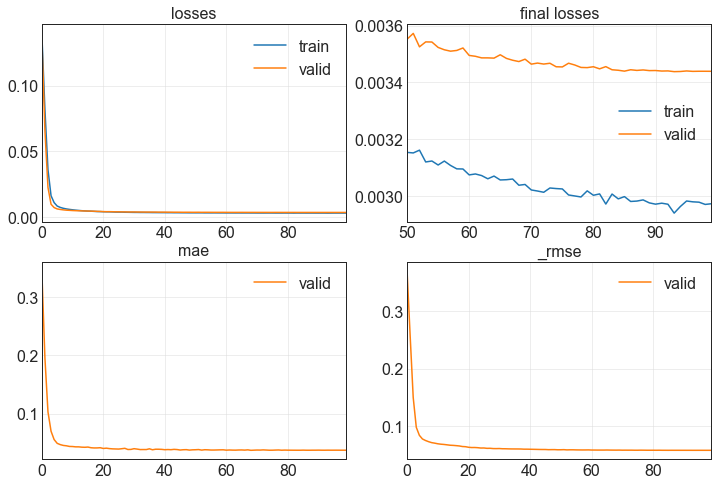

342.03442335128784                                                                                                     
[0.0029719718731939793, 0.0034391453955322504, 0.03713178262114525, 0.05864423140883446]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}
TCN                                                                                                                    
 99%|████████████████████████████████████████▌| 99/100 [18:39:56<10:57, 657.01s/trial, best loss: 0.003214011201635003]

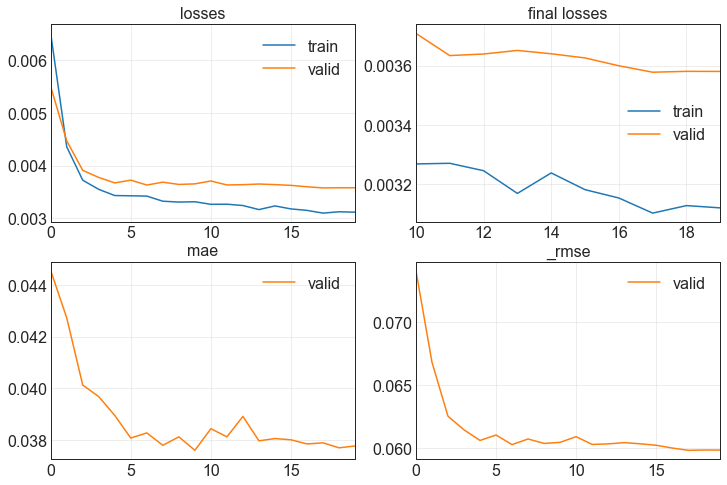

266.73520946502686                                                                                                     
[0.0031189885921776295, 0.0035804626531898975, 0.03776757791638374, 0.0598369762301445]                                
100%|████████████████████████████████████████| 100/100 [18:44:23<00:00, 674.63s/trial, best loss: 0.003214011201635003]


In [57]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=max_evals,  # test trials
    trials=trials)

In [58]:
print("Best parameters:")
print(space_eval(search_space, best))
params = space_eval(search_space, best)

Best parameters:
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000022951848438>, 'patience': 10}


In [59]:
# only for debug
# params = {'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 5, 'optimizer': Adam, 'patience': 10}

# Retrain the model with best hyperparameter

We use training data for training and validation data for (possible) early stopping:

In [60]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [61]:
X.shape

(38467, 144, 10)

In [62]:
y.shape

(38467, 144)

In [63]:
batch_size = params["batch_size"]

In [64]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
# set num_workers for memory bottleneck
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)

Create the model:

In [65]:
arch = TCN
k = {
    'layers': params['layers'],
    'ks': params['ks'],
    'conv_dropout': params['conv_dropout']
}
model = create_model(arch, dls=dls, **k)
print(model.__class__.__name__)

TCN


In [66]:
# Add a Sigmoid layer
model = nn.Sequential(model, nn.Sigmoid())

In [67]:
model

Sequential(
  (0): TCN(
    (tcn): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(144, 25, kernel_size=(7,), stride=(1,), padding=(6,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.0, inplace=False)
        (conv2): Conv1d(25, 25, kernel_size=(7,), stride=(1,), padding=(6,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.0, inplace=False)
        (net): Sequential(
          (0): Conv1d(144, 25, kernel_size=(7,), stride=(1,), padding=(6,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.0, inplace=False)
          (4): Conv1d(25, 25, kernel_size=(7,), stride=(1,), padding=(6,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.0, inplace=False)
        )
        (downsample): Conv1d(144, 25, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
      (1): TemporalBlock(
        (conv1): Conv1d(25, 25, kernel_size=(7,), stride=(1,), padding

In [68]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

63,594 total parameters.
63,594 training parameters.


Training the model:

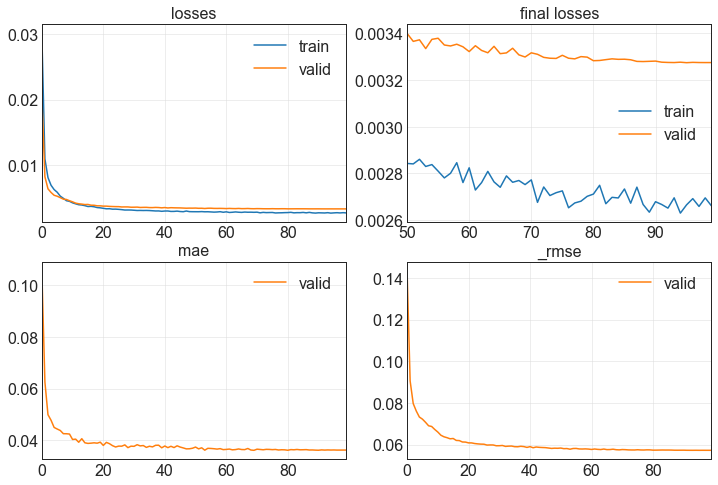

In [69]:
learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
start = time.time()
learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                    cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
training_time = time.time() - start
learn.plot_metrics()

Evaluate the model:

In [70]:
dls = learn.dls
valid_dl = dls.valid

In [71]:
test_ds = valid_dl.dataset.add_test(X_test, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

9619


In [72]:
start = time.time()
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
prediction_time = time.time() - start
test_probas, test_targets, test_preds

(tensor([[0.0031, 0.0132, 0.0302,  ..., 0.0269, 0.1997, 0.8537],
         [0.0030, 0.0132, 0.0313,  ..., 0.0271, 0.1975, 0.8720],
         [0.0024, 0.0123, 0.0298,  ..., 0.0246, 0.2065, 0.8581],
         ...,
         [0.0188, 0.0461, 0.1095,  ..., 0.1343, 0.4519, 0.9827],
         [0.0204, 0.0462, 0.0897,  ..., 0.1513, 0.4401, 0.9782],
         [0.0174, 0.0475, 0.0967,  ..., 0.1529, 0.4674, 0.9804]]),
 tensor([[0.0000, 0.0020, 0.0167,  ..., 0.0065, 0.2165, 0.8989],
         [0.0000, 0.0040, 0.0109,  ..., 0.0057, 0.2154, 0.7845],
         [0.0000, 0.0020, 0.0082,  ..., 0.0079, 0.2064, 1.0000],
         ...,
         [0.6255, 0.0400, 0.1464,  ..., 0.0790, 0.4122, 0.8162],
         [0.6294, 0.0634, 0.2009,  ..., 0.0886, 0.4169, 0.7650],
         [0.4050, 0.0551, 0.1543,  ..., 0.0931, 0.3980, 0.9314]]),
 tensor([[0.0031, 0.0132, 0.0302,  ..., 0.0269, 0.1997, 0.8537],
         [0.0030, 0.0132, 0.0313,  ..., 0.0271, 0.1975, 0.8720],
         [0.0024, 0.0123, 0.0298,  ..., 0.0246, 0.2065, 0.

In [73]:
test_targets.shape

torch.Size([9619, 144])

In [74]:
test_preds.shape

torch.Size([9619, 144])

In [75]:
y_true = test_targets.numpy()
y_pred = test_preds.numpy()

Reshape the data into multiple steps

In [76]:
y_true = y_true.reshape(y_true.shape[0], horizon, -1)
y_pred = y_pred.reshape(y_pred.shape[0], horizon, -1)

In [77]:
y_true.shape

(9619, 1, 144)

In [78]:
y_pred.shape

(9619, 1, 144)

Transform the data in the normal range:

In [79]:
def inverse_normalization(prediction, y, max_list, min_list):
    inverse_prediction = prediction * (max_list - min_list) + min_list
    inverse_y = y * (max_list - min_list) + min_list

    return inverse_prediction, inverse_y

In [80]:
y_true_list = []
y_pred_list = []
for i in range(y_true.shape[0]):
    y_true_tmp = []
    y_pred_tmp = []
    for step in range(y_true.shape[1]):
        inverse_prediction, inverse_y = inverse_normalization(y_pred[i, step, :], y_true[i, step, :], max_list, min_list)
        
        y_true_tmp.append(inverse_y)
        y_pred_tmp.append(inverse_prediction)
    y_true_list.append(y_true_tmp)
    y_pred_list.append(y_pred_tmp)

In [81]:
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

In [82]:
y_true.shape

(9619, 1, 144)

In [83]:
y_pred.shape

(9619, 1, 144)

# Save Predictions and Evaluate Model

Save true values and predictions first:

In [84]:
pickle.dump(y_pred, open(y_pred_fn, 'wb'))

In [85]:
pickle.dump(y_true, open(y_true_fn, 'wb'))

The training and test time spent:

In [86]:
print('Training time (in seconds): ', training_time)
print('Test time (in seconds): ', prediction_time)

Training time (in seconds):  1296.9543437957764
Test time (in seconds):  1.8182284832000732


In [92]:
print('Training time (in seconds) per epoch: ', 1296.9543437957764 / 100)

Training time (in seconds) per epoch:  12.969543437957764


Calculate the RMSE and MAE for differnt time steps:

In [88]:
for step in range(horizon):
    print('Prediction for the next %d frame' % (step + 1))
    print('RMSE: ', math.sqrt(mean_squared_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten())) / 1000)  # in Mbps
    print('MAE: ', mean_absolute_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten()) / 1000 )

Prediction for the next 1 frame
RMSE:  12.62272315116463
MAE:  6.519696143126478


Plot the RMSE and MAE distributions for each time step:

In [89]:
def plot_RMSE(y_true, y_pred, fn, xlim=60):
    RMSE_list = []

    for i in range(y_true.shape[0]):
        rmse = math.sqrt(mean_squared_error(y_true[i].flatten(), y_pred[i].flatten())) / 1000
        RMSE_list.append(rmse)
    
    data = RMSE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("RMSE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

In [90]:
def plot_MAE(y_true, y_pred, fn, xlim=60):
    MAE_list = []

    for i in range(y_true.shape[0]):
        mae = mean_absolute_error(y_true[i].flatten(), y_pred[i].flatten()) / 1000
        MAE_list.append(mae)
    
    data = MAE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("MAE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

TCN_TM-minmax_RMSE-10-1-step-1.pdf
TCN_TM-minmax_MAE-10-1-step-1.pdf


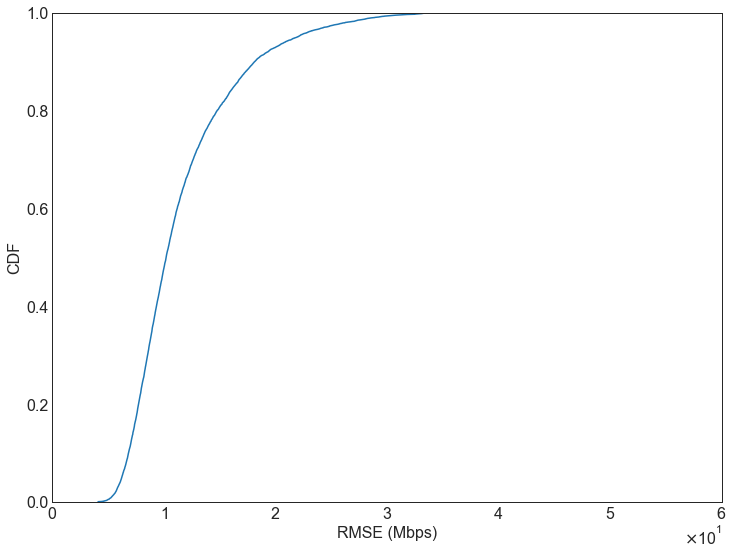

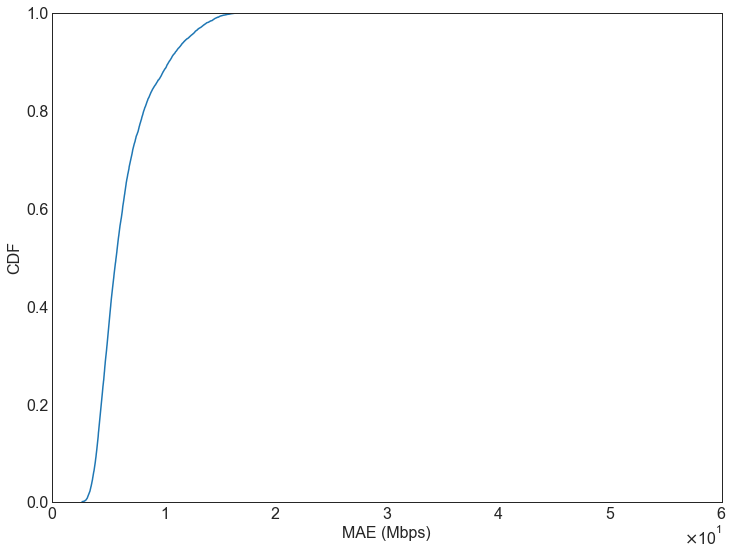

In [91]:
for step in range(horizon):
    fn = RMSE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_RMSE(y_true[:, step, :], y_pred[:, step, :], fn)
    
    fn = MAE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_MAE(y_true[:, step, :], y_pred[:, step, :], fn)